In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor

# Библиотеки для нейронной сети
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, lr_scheduler

## EDA, разведывательный анализ

В датасете 9 столбцов.

- Date: Дата и время снятия показаний

- City: Город, в котором снимают показания

- CO: Концентрация угарного газа

- NO2: Концентрация диоксида азота

- SO2: Концентрация сернистого газа

- O3: Концентрация озона

- PM2.5: Концентрация мелких частиц

- PM10: Концентрация крупных частиц

- AQI: Индекс качества воздуха - таргентный столбец

In [2]:
main_df = pd.read_csv('Air_Quality.csv', parse_dates=['Date'], encoding='utf-8')

print(main_df.head(5))

                       Date      City     CO    NO2   SO2    O3  PM2.5  PM10  \
0 2023-01-01 00:00:00+00:00  Brasilia  292.0  30.15  1.10  23.0   11.1  15.8   
1 2023-01-01 01:00:00+00:00  Brasilia  291.0  28.95  1.15  24.0   12.4  17.7   
2 2023-01-01 02:00:00+00:00  Brasilia  289.0  27.25  1.25  25.0   13.0  18.5   
3 2023-01-01 03:00:00+00:00  Brasilia  275.0  23.70  1.30  28.0    9.2  13.1   
4 2023-01-01 04:00:00+00:00  Brasilia  246.0  19.35  1.25  32.0    6.8   9.7   

         AQI  
0  21.158330  
1  20.825000  
2  20.474998  
3  20.074999  
4  19.324999  


In [3]:
# Вывод информации о датасете
print(main_df.describe(include='all'))

                             Date      City            CO           NO2  \
count                       52560     52560  52560.000000  52560.000000   
unique                        NaN         6           NaN           NaN   
top                           NaN  Brasilia           NaN           NaN   
freq                          NaN      8760           NaN           NaN   
mean    2023-07-02 11:30:00+00:00       NaN    273.372565     28.930514   
min     2023-01-01 00:00:00+00:00       NaN     48.000000      0.000000   
25%     2023-04-02 05:45:00+00:00       NaN    160.000000     11.100000   
50%     2023-07-02 11:30:00+00:00       NaN    224.000000     22.100000   
75%     2023-10-01 17:15:00+00:00       NaN    335.000000     38.700000   
max     2023-12-31 23:00:00+00:00       NaN   2145.000000    251.900000   
std                           NaN       NaN    171.578815     25.473936   

                 SO2            O3         PM2.5          PM10           AQI  
count   52560.000000

In [4]:
# Информация о столбцах в датасете
print(main_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    52560 non-null  datetime64[ns, UTC]
 1   City    52560 non-null  object             
 2   CO      52560 non-null  float64            
 3   NO2     52560 non-null  float64            
 4   SO2     52560 non-null  float64            
 5   O3      52560 non-null  float64            
 6   PM2.5   52560 non-null  float64            
 7   PM10    52560 non-null  float64            
 8   AQI     52560 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7), object(1)
memory usage: 3.6+ MB
None


In [5]:
#Проверка на пустые значения
for column in main_df.columns:
    count_isna = main_df[column].isna().sum()
    print(f"{column} has {count_isna} empty values")

Date has 0 empty values
City has 0 empty values
CO has 0 empty values
NO2 has 0 empty values
SO2 has 0 empty values
O3 has 0 empty values
PM2.5 has 0 empty values
PM10 has 0 empty values
AQI has 0 empty values


Как мы видим из анализа, в датасете отсутствуют пустые и NaN значения. 
Теперь нужно привести дату к удобному виду и разделить на столбцы для определения закономерностей - месяц, название месяца, дата, час и день недели.

In [6]:
# Разделение столцба с датой для удобного взаимодействия
main_df['Month'] = main_df['Date'].dt.month
main_df['Year'] = main_df['Date'].dt.year
main_df['Month_Name'] = main_df['Date'].dt.month_name()
main_df['Day'] = main_df['Date'].dt.day
main_df['Hour'] = main_df['Date'].dt.hour
main_df['Weekday'] = main_df['Date'].dt.day_name()

### График 1 - AQI с усредненным значений по дням для каждого месяца

График показывает динамику среднего дневного индекса качества воздуха (AQI) в разбивке по месяцам.

Каждый субграфик представляет один месяц. Это позволяет анализировать изменения AQI в течение месяца, а также сравнивать уровни загрязнения между разными месяцами. Также использование средних дневных значений помогает сгладить случайные колебания и выявить общие тенденции.

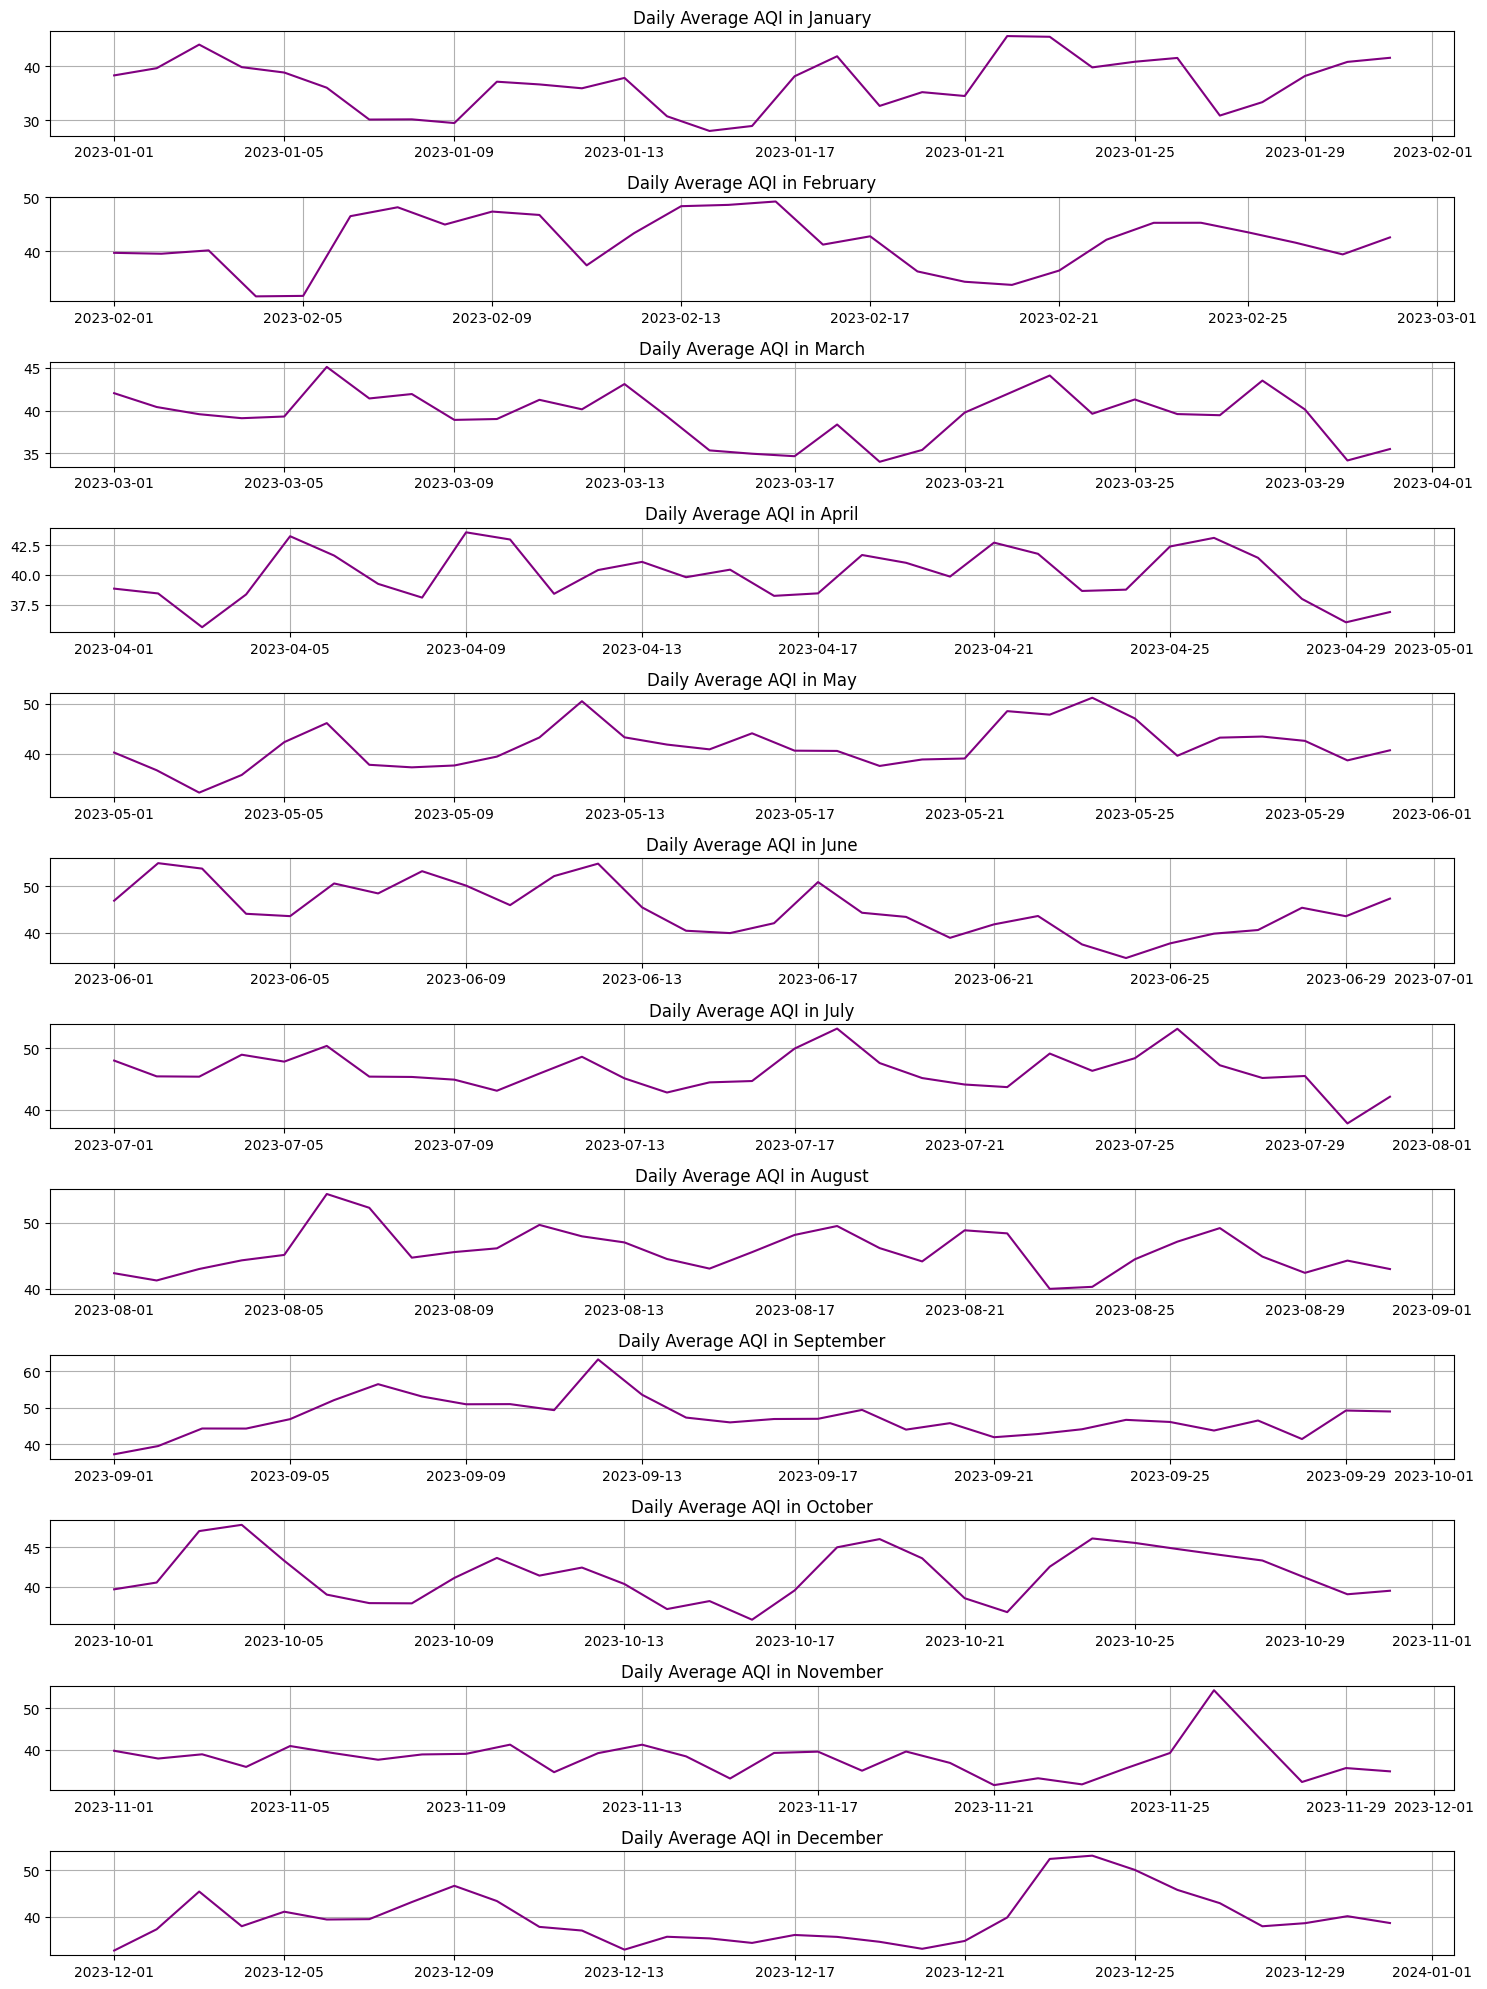

In [7]:
# Создаем датафрейм с усредненными дневными значениями AQI
# Группируем по году, месяцу и дню, вычисляя среднее AQI для каждой группы
daily_avg = main_df.groupby(['Year', 'Month', 'Day']).agg({'AQI': 'mean'}).reset_index()

# Создаем столбец с полной датой для удобства построения графиков
daily_avg['Date'] = pd.to_datetime(daily_avg[['Year', 'Month', 'Day']])

# Добавляем название месяца для подписей на графике
daily_avg['Month_Name'] = daily_avg['Date'].dt.month_name() 

# Создаем сетку графиков - по одному на каждый месяц
plt.figure(figsize=(15, 20))  # Устанавливаем большой размер фигуры для удобства просмотра

# Генерируем субграфики для каждого месяца
for i, month in enumerate(sorted(main_df['Month'].unique()), 1):
    plt.subplot(len(main_df['Month'].unique()), 1, i)  # Создаем субграфик в сетке
    
    # Фильтруем данные для текущего месяца
    month_data = daily_avg[daily_avg['Month'] == month]
    
    # Строим линейный график AQI по дням месяца
    plt.plot(month_data['Date'], month_data['AQI'], label=f'Month {month}', color='purple')
    
    # Добавляем заголовок и сетку
    plt.title(f'Daily Average AQI in {month_data["Month_Name"].iloc[0]}')
    plt.grid(True)

# Оптимизируем расположение графиков
plt.tight_layout()
plt.show()

Вывод:
1) Имеют место сезонные колебания качества воздуха - в некоторые месяцы наблюдаются устойчиво повышенные или пониженные значения AQI
2) Внутримесячная динамика часто имеет волнообразный характер, что может быть связано с периодичностью промышленных выбросов или погодными условиями
3) Особого внимания заслуживают резкие всплески AQI (например, в сентябре), которые могут указывать на экстремальные события загрязнения воздуха

### График 2 - Средние значения AQI по часам

Если суточные колебания AQI связаны с человеческой активностью, то мы должны наблюдать:
1) Рост загрязнения в часы пик (утренние/вечерние)
2) Снижение ночью при минимальной активности

Проверим эту гипотезу

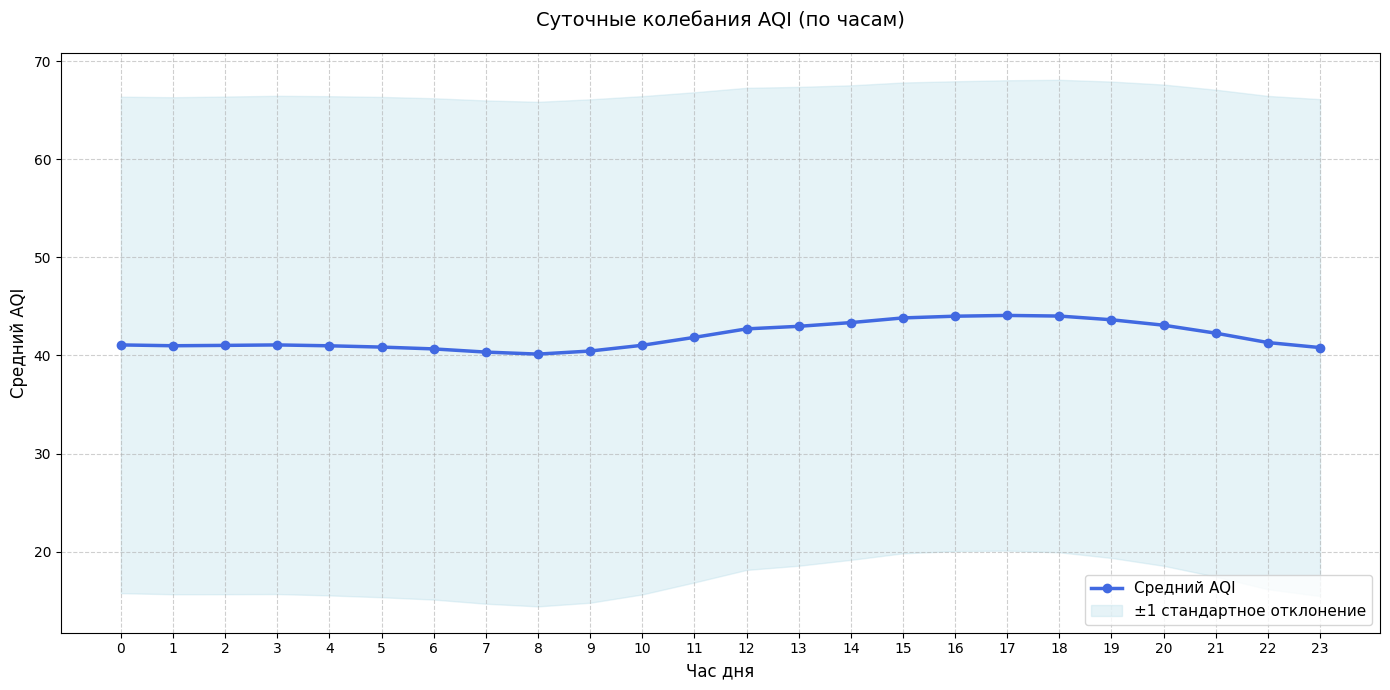

In [8]:
# Анализ почасовой динамики AQI с учетом стандартного отклонения
# Группируем данные по часам, вычисляя среднее и стандартное отклонение AQI
hourly_avg = main_df.groupby('Hour').agg({
    'AQI': ['mean', 'std']  # Два показателя для анализа изменчивости
}).reset_index()

# Переименовываем колонки для удобства работы
hourly_avg.columns = ['Hour', 'AQI_mean', 'AQI_std']

# Создаем график с областями отклонений
plt.figure(figsize=(14, 7))  # Оптимальный размер для чтения подписей

# Основная линия - средние значения AQI по часам
plt.plot(hourly_avg['Hour'], hourly_avg['AQI_mean'], 
         color='royalblue',       # Выбор цвета для лучшей видимости
         linewidth=2.5,           # Акцент на основной тенденции
         marker='o',              # Маркеры для точных значений
         label='Средний AQI')

# Заполненная область - диапазон изменчивости (±1σ)
plt.fill_between(hourly_avg['Hour'],
                 hourly_avg['AQI_mean'] - hourly_avg['AQI_std'],  # Нижняя граница
                 hourly_avg['AQI_mean'] + hourly_avg['AQI_std'],  # Верхняя граница
                 color='lightblue',  # Полупрозрачный фон
                 alpha=0.3,          # Прозрачность для визуального комфорта
                 label='±1 стандартное отклонение')

# Форматирование графика
plt.title('Суточные колебания AQI (по часам)', fontsize=14, pad=20)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Средний AQI', fontsize=12)
plt.xticks(range(0, 24))  # Все часы на оси X
plt.grid(True, linestyle='--', alpha=0.6)  # Сетка для удобства чтения значений
plt.legend(fontsize=11)  # Объяснение элементов графика
plt.tight_layout()  # Автоматическая оптимизация расположения

plt.show()

Вывод:

Гипотеза частично подтверждается.

Четкий дневной пик (11-19 ч) соответствует времени работы предприятий и транспорта. В ночное время средний AQI ниже, а самое низкое среднее значение заметно в 8.00, что соответствует времени начала работы многих людей.

### График 3 - Средние значения AQI по дням недели и по часам

Если мы утверждаем, что AQI зависит от человеческой активности, то мы должны увидеть более высокие средние показатели в будние дни и снижение этой величины в выходные. Также могут быть особые паттерны в пятницу вечером и в воскресенье, которые будут связаны с изменением поведения людей (например, больше поездок за город)

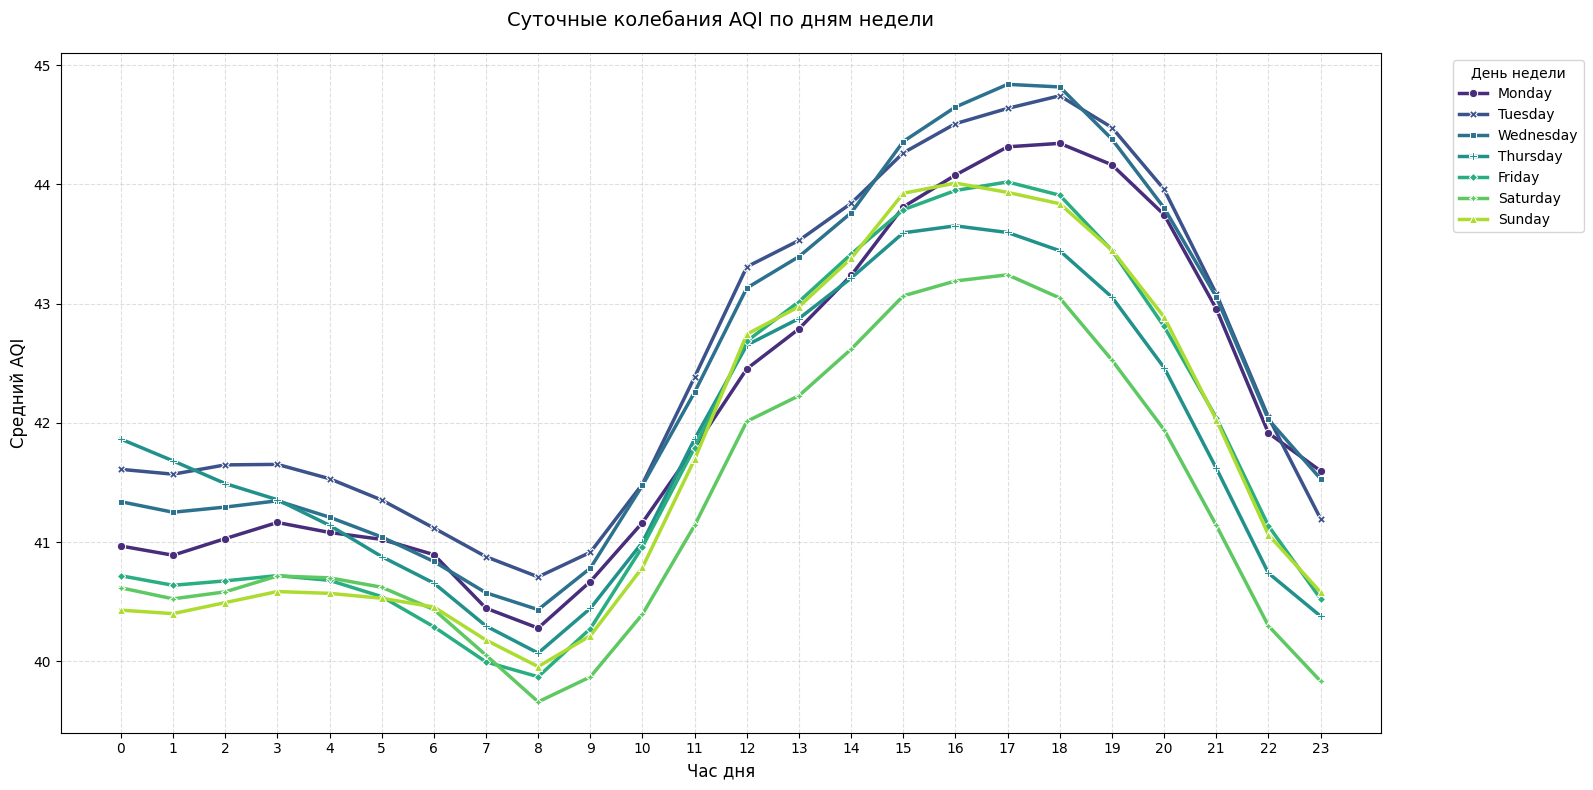

In [9]:
# Группируем данные по часам и дням недели, вычисляя средний AQI
hourly_weekday_avg = main_df.groupby(['Hour', 'Weekday']).agg({
    'AQI': 'mean'  # Усредняем AQI для каждого часа и дня недели
}).reset_index()

# Задаем порядок дней недели для корректного отображения
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_weekday_avg['Weekday'] = pd.Categorical(
    hourly_weekday_avg['Weekday'], 
    categories=weekday_order, 
    ordered=True
)

# Строим график с разными линиями для каждого дня недели
plt.figure(figsize=(16, 8))  # Увеличиваем размер для удобства просмотра
sns.lineplot(
    data=hourly_weekday_avg, 
    x='Hour', 
    y='AQI', 
    hue='Weekday',  # Разные цвета для дней недели
    palette='viridis',  # Цветовая схема
    linewidth=2.5,  # Толщина линий
    style='Weekday',  # Разные стили линий (на случай ч/б печати)
    markers=True,  # Добавляем маркеры для наглядности
    dashes=False  # Сплошные линии
)

# Оформление графика
plt.title('Суточные колебания AQI по дням недели', fontsize=14, pad=20)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Средний AQI', fontsize=12)
plt.xticks(range(0, 24))  # Отмечаем все часы на оси X
plt.grid(True, linestyle='--', alpha=0.4)  # Добавляем сетку
plt.legend(title='День недели', bbox_to_anchor=(1.05, 1), loc='upper left')  # Выносим легенду в сторону
plt.tight_layout()  # Оптимизируем расположение элементов
plt.show()


Вывод: 
Наша гипотеза частично подтверждена.<br>
В будние дни AQI стабильно выше, чем в выходные. <br>
Утренний пик в выходные не наблюдается, так как людям не нужно ехать на работу.<br>
Величина AQI в воскресенье после обеда растет (14-18 ч), что свидетельствует о поездках людей. Также воскресенье имеет низкий AQI ночью, что может быть связано с закрытием некоторых предприятий.

### График 4 - Гистограммы для каждого показателя

Основные загрязнители воздуха имеют разную природу происхождения, следовательно, можно предположить, что их распределения должны существенно отличаться:
1) CO, NO2, SO2 — ожидаем правостороннюю асимметрию (много низких значений и редкие выбросы)
2) O3 — возможно бимодальное распределение (фотохимические реакции зависят от времени суток)
3) PM2.5/PM10 — логнормальное распределение (характерно для частиц)
4) AQI — мультимодальность, отражающая комбинацию разных загрязнителей

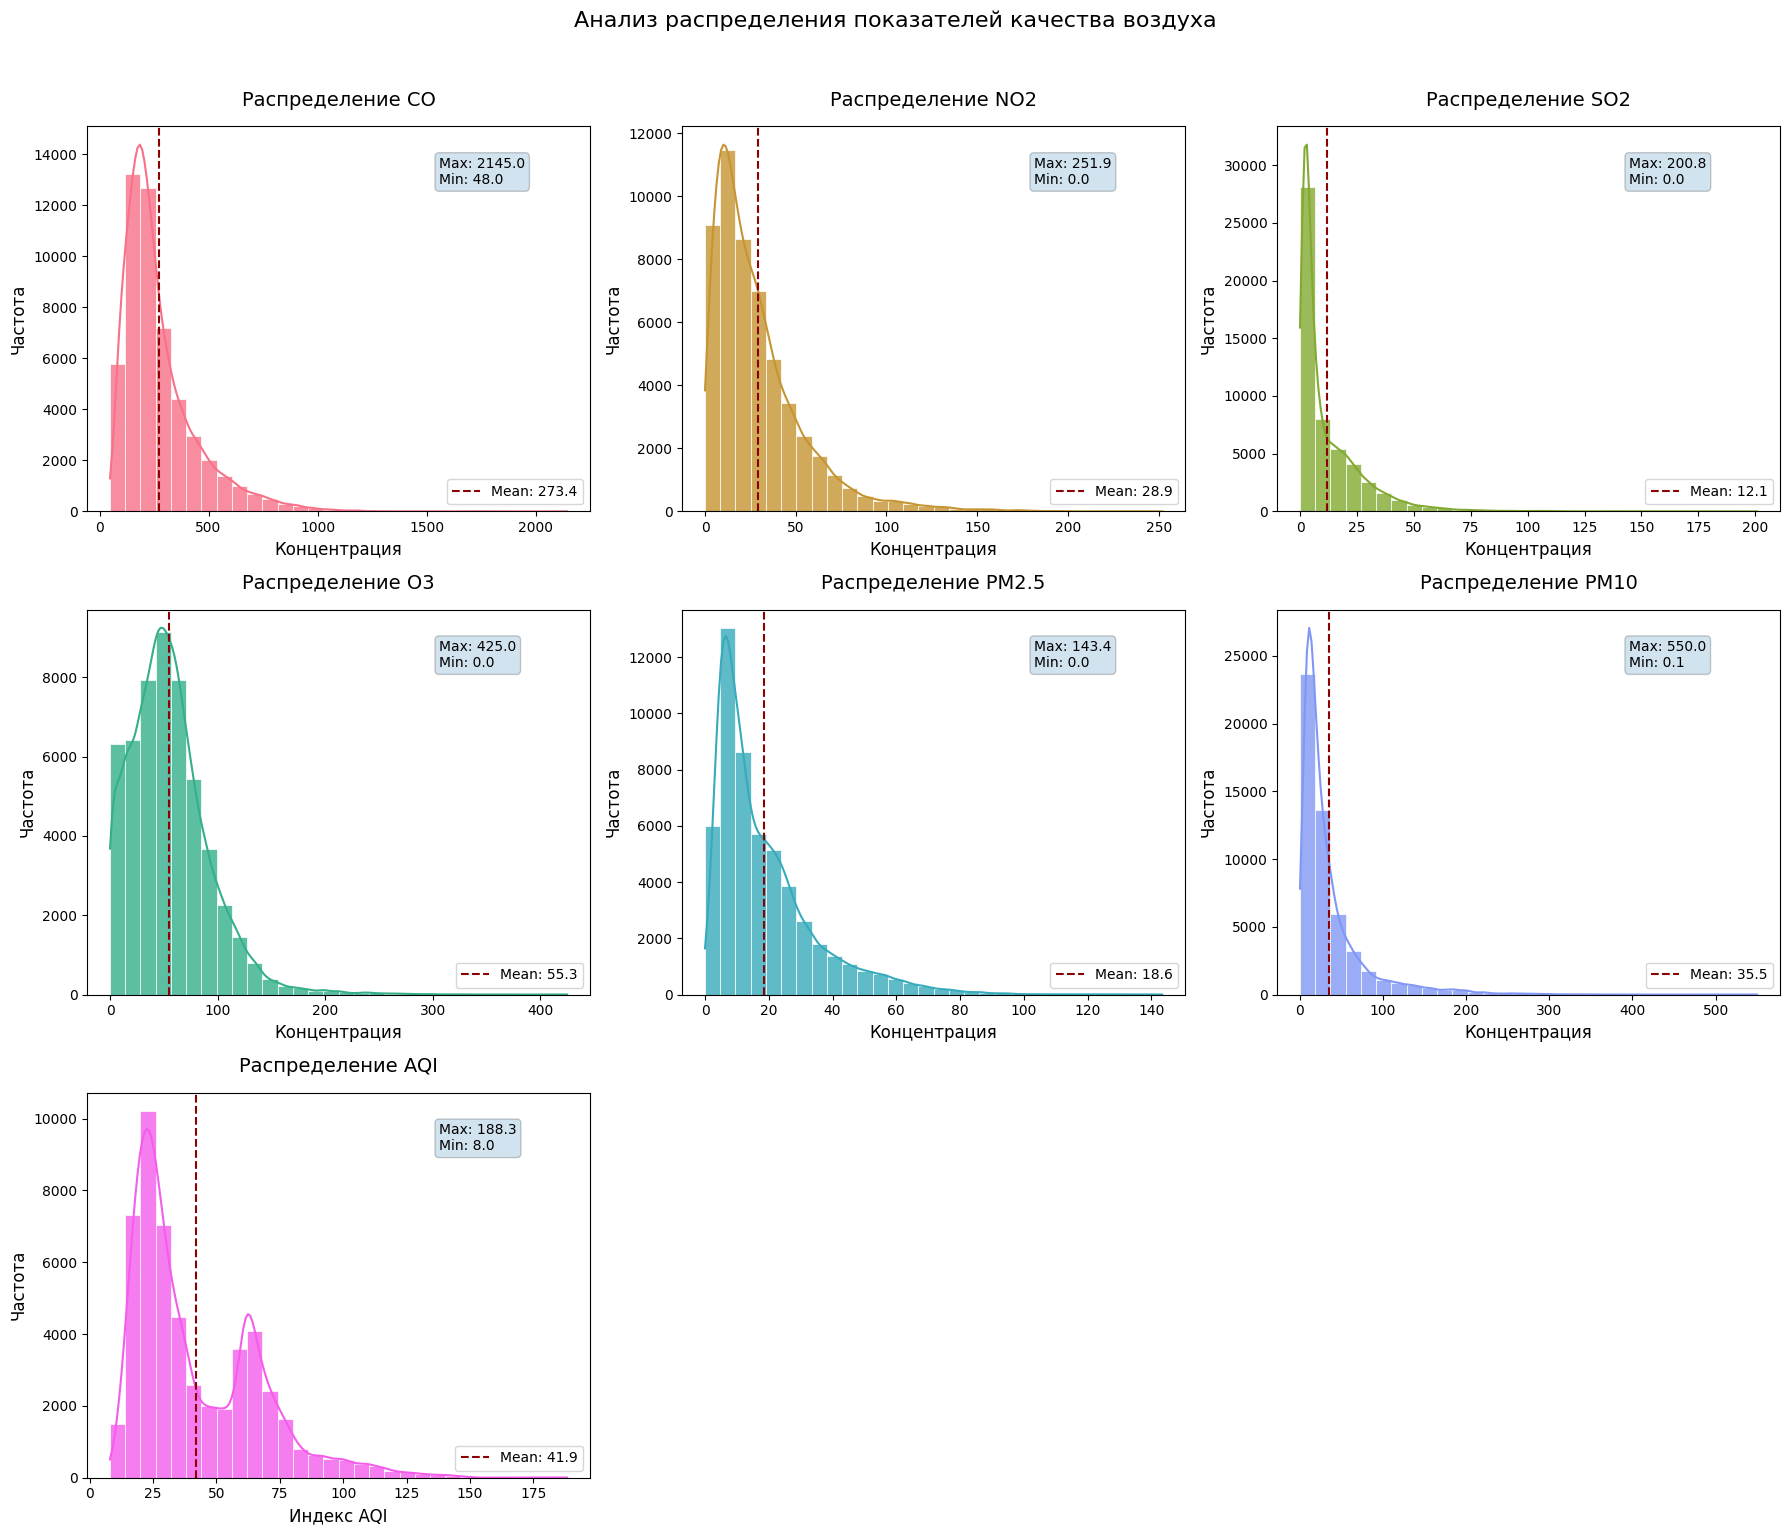

In [10]:
# Список анализируемых показателей
pollutants = ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI']

# Расчет структуры сетки графиков
n_cols = 3  # 3 графика в строке
n_rows = math.ceil(len(pollutants) / n_cols)  # Автоподбор строк

# Создание сетки графиков с настроенным размером
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()  # Преобразование в плоский массив для удобства

# Палитра цветов для наглядности
colors = sns.color_palette("husl", len(pollutants))

# Построение гистограмм для каждого показателя
for i, (col, color) in enumerate(zip(pollutants, colors)):
    # Основная гистограмма с ядерной оценкой плотности
    sns.histplot(main_df[col], kde=True, ax=axes[i],
                color=color,
                bins=30,  # Оптимальное число бинов
                edgecolor='w',  # Белые границы столбцов
                linewidth=0.5,
                alpha=0.8)  # Полупрозрачность
    
    # Линия среднего значения
    mean_val = main_df[col].mean()
    axes[i].axvline(mean_val, color='darkred',
                   linestyle='--',
                   linewidth=1.5,
                   label=f'Mean: {mean_val:.1f}')
    
    # Настройка заголовков и подписей
    axes[i].set_title(f'Распределение {col}', pad=15, fontsize=14)
    axes[i].set_xlabel('Концентрация' if col != 'AQI' else 'Индекс AQI', fontsize=12)
    axes[i].set_ylabel('Частота', fontsize=12)
    axes[i].legend()
    
    # Аннотация с экстремальными значениями
    annot_text = f"Max: {main_df[col].max():.1f}\nMin: {main_df[col].min():.1f}"
    axes[i].annotate(annot_text, xy=(0.7, 0.85),
                    xycoords='axes fraction',
                    bbox=dict(boxstyle='round', alpha=0.2))

# Скрытие пустых графиков в сетке
for j in range(len(pollutants), len(axes)):
    axes[j].axis('off')

# Общий заголовок
plt.suptitle('Анализ распределения показателей качества воздуха',
            y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Вывод:

Некоторые гипотезы были подтверждены.
1) Правосторонняя асимметрия у CO, NO2, SO2 — подтверждает редкие, но опасные выбросы
2) Логнормальное распределение PM2.5/PM10 — характерно для частиц
Не подтверждена бимодальность O3

AQI показывает сложное мультимодальное распределение с пиками в зонах:
20-30 (норма), 60-70 (норма)

### График 5 - Анализ выбросов показателей воздуха

Если основные загрязнители воздуха имеют разную устойчивость к рассеиванию, то:
1) Газы (CO, NO2, SO2, O3) будут иметь больше выбросов из-за высокой летучести
2) Твердые частицы (PM2.5, PM10) покажут более стабильное распределение с меньшим числом экстремальных значений

Средние значения скорее всего будут существенно ниже выбросов, что указывает на эпизодический характер сильного загрязнения.

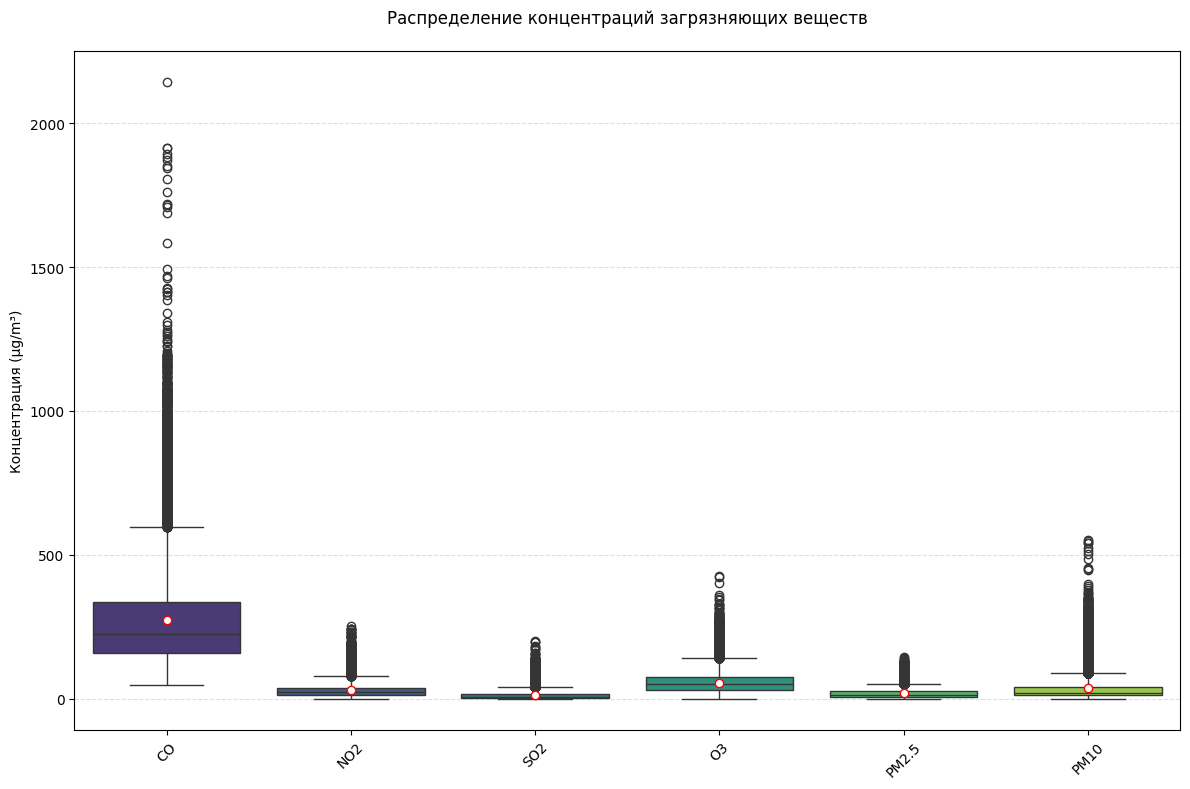

In [11]:
# Создаем boxplot для визуализации распределений и выбросов
plt.figure(figsize=(12, 8))  # Оптимальный размер для 6 показателей

# Построение boxplot с настройками:
sns.boxplot(
    data=main_df[['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10']],  # Выбор показателей
    palette="viridis",  # Цветовая схема
    whis=1.5,  # Коэффициент для определения выбросов (стандарт - 1.5*IQR)
    showmeans=True,  # Отображение средних значений
    meanprops={  # Стиль маркера для среднего
        "marker":"o", 
        "markerfacecolor":"white", 
        "markeredgecolor":"red"
    }
)

# Настройка оформления:
plt.title('Распределение концентраций загрязняющих веществ', pad=20)
plt.ylabel('Концентрация (µg/m³)')  # Единицы измерения
plt.xticks(rotation=45)  # Наклон подписей для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.4)  # Сетка только по оси Y
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

Вывод:
Подтвержденные гипотезы:
1) Газы демонстрируют больше выбросов (длинные "усы" у CO, NO2, О3)
2) PM2.5/PM10 имеют компактное распределение — подтверждает устойчивость частиц
3) Средние значения (белые точки) близки к медианам для PM, но смещены вверх для газов

Присутствуют экстремальные выбросы СО и PM10, что может свидетельствовать об аварийных промышленных выбросах. Также замечены достаточно высокие выбросы О3, но они требуют более глубокой проверки на корреляцию с температурой, что не входит в нашу задачу.

### График 6 - Скрипичная диаграмма плотности распределения

Если распределение загрязнителей отражает их физико-химические свойства, то:
1) Газы (CO, NO₂, SO₂, O₃) могут показать полимодальные распределения из-за зависимости от времени суток/сезона
2) Твердые частицы (PM2.5, PM10) будут иметь положительную асимметрию с длинным хвостом высоких концентраций
3) Ширина «скрипки» будет коррелировать с изменчивостью условий рассеивания для каждого вещества

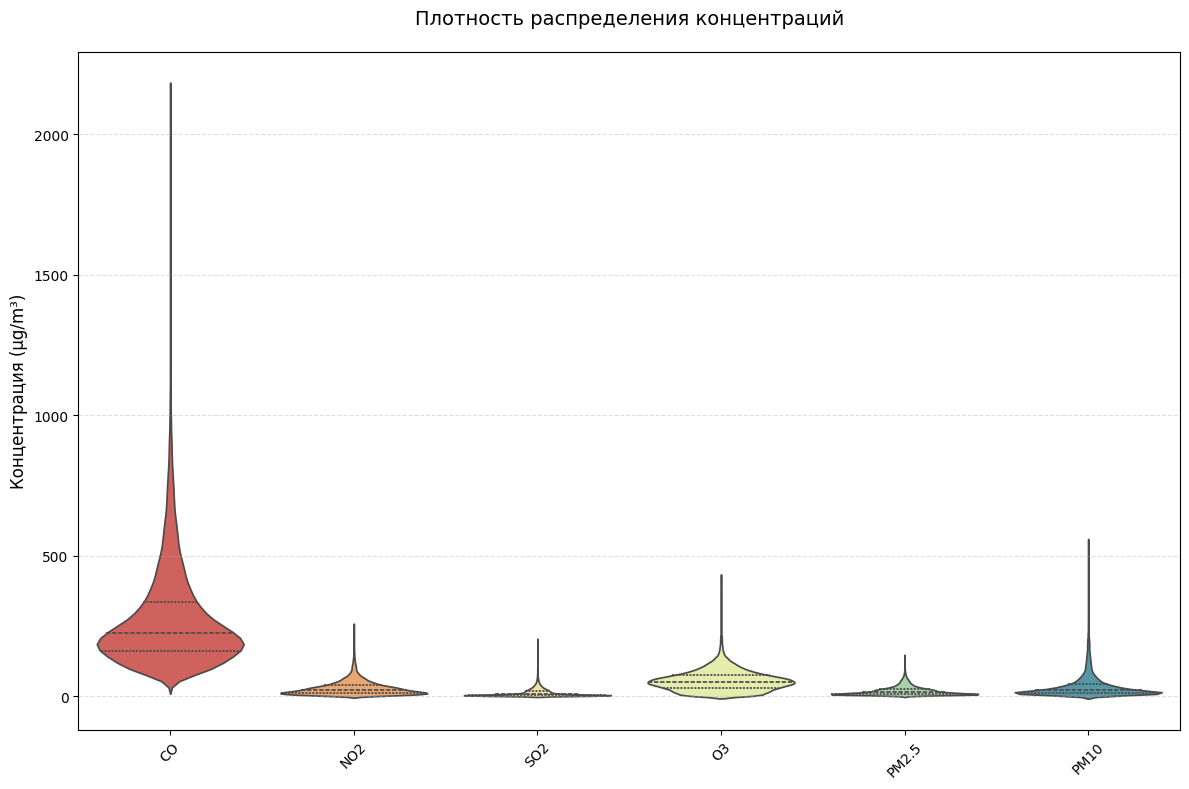

In [12]:
# Создаем скрипичную диаграмму для анализа плотности распределений
plt.figure(figsize=(12, 8))  # Размер обеспечивает читаемость всех 6 показателей

sns.violinplot(
    data=main_df[['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10']],  # Выбор показателей
    inner="quartile",  # Отображение медианы и квартилей внутри
    palette="Spectral",  # Цветовая схема для наглядности
    density_norm='width'  # Нормализация ширины для корректного сравнения
)

# Настройка визуализации:
plt.title('Плотность распределения концентраций', pad=20, fontsize=14)
plt.ylabel('Концентрация (µg/m³)', fontsize=12)
plt.xticks(rotation=45)  # Наклон подписей для компактности
plt.grid(axis='y', linestyle='--', alpha=0.4)  # Сетка только по оси Y
plt.tight_layout()  # Автоматическая оптимизация отступов
plt.show()

Вывод:
Подтвержденные закономерности:
1) Асимметрия PM2.5/PM10 — длинный хвост в зоне высоких концентраций (эпизоды смога)
2) Полимодальные распределения газов

Также стоит отметить: 
1) Основная мода в зоне низких концентраций
2) Длинный хвост до 100+ µg/m³ (промзоны)

### График 7 - Анализ выбросов AQI по дням года с установленным ВОЗ порогом

Если экстремальные значения AQI связаны с сезонными явлениями или особыми событиями, то:
1) Выбросы будут группироваться в определенные периоды года (отопительный сезон, лесные пожары)
2) Превышения порога ВОЗ (AQI>100) будут редкими, но значимыми
3) Аномальные значения (AQI>150) требуют отдельного исследования

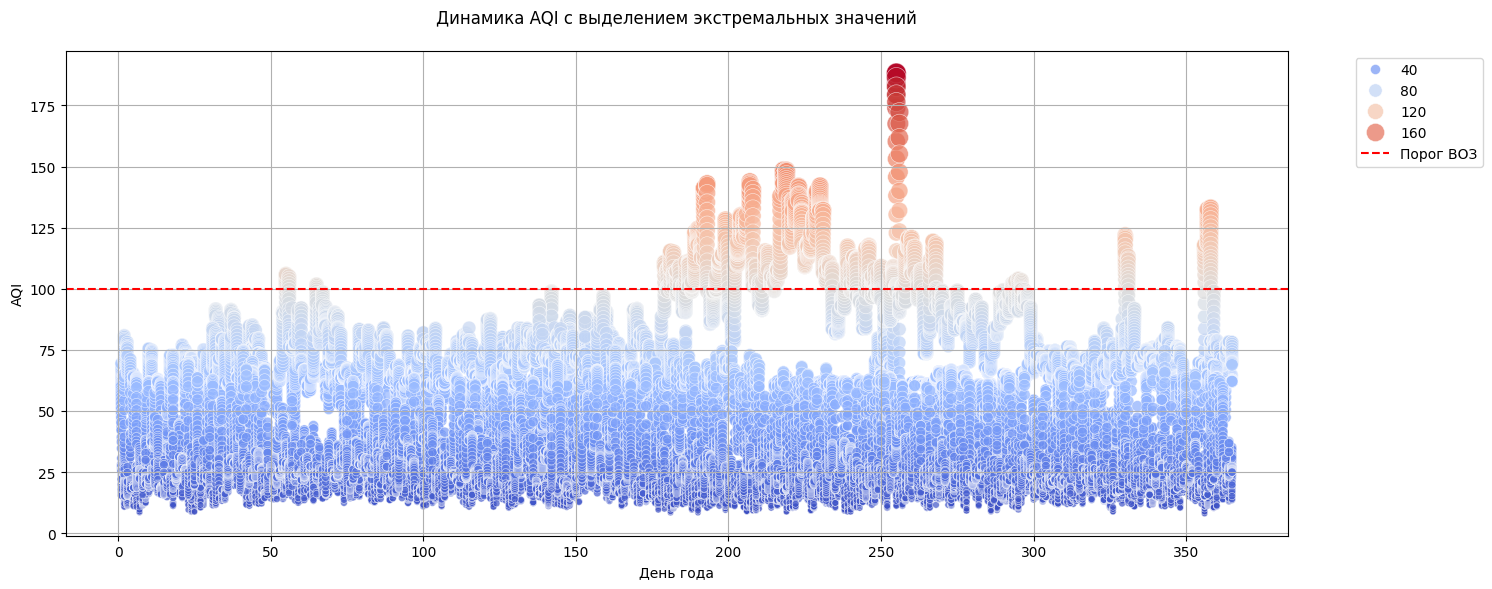

In [13]:
# Добавляем столбец с номером дня в году
main_df['Day_of_Year'] = main_df['Date'].dt.dayofyear

# Строим точечный график с настраиваемыми параметрами визуализации
plt.figure(figsize=(15, 6))
sns.scatterplot(
    x='Day_of_Year', y='AQI', data=main_df,
    hue='AQI',  # Цвет точек по значению AQI
    palette="coolwarm",  # Тепло-холодная схема для интуитивного понимания
    size='AQI',  # Размер точек по значению AQI
    sizes=(20, 200),  # Диапазон размеров
    alpha=0.7  # Полупрозрачность для перекрывающихся точек
)

# Оформление графика
plt.title('Динамика AQI с выделением экстремальных значений', pad=20)
plt.xlabel('День года')
plt.ylabel('AQI')
plt.axhline(y=100, color='red', linestyle='--', label='Порог ВОЗ')  # Референсная линия
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Вынос легенды
plt.grid()  # Сетка для удобства чтения
plt.tight_layout()
plt.show()

Вывод:<br>
Из графика видны некоторые критические значения: экстремальный выброс на 255 день года (AQI ~200). Возможные причины такого выброса - лесные пожары, промышленная авария.<br>
Также в период со 180 до 235 дня наблюдалось превышение нормы (120-150). Это летние месяцы, поэтому такое повышение AQI может носить сезонный характер, причинами которого будет фотохимический смог (высокие температуры и безветрие), а также пыльные бури. Помимо этого, может повлиять увеличение энергопотребления (кондиционирование)

Общая статистика:
1) 85% дней в году AQI ниже порога ВОЗ (100) - удовлетворительное качество воздуха
2) Фоновые значения преимущественно в диапазоне 25-70 (норма)

### График 8 - Heatmap по городам

Если уровень загрязнения воздуха зависит от географического положения и сезонности, то:
1) Города в промышленных регионах будут показывать стабильно высокий AQI круглый год
2) Сезонные колебания будут особенно заметны в городах с летним смогом (фотохимические реакции), а также с туристическим "наплывом"<br>

Приморские города могут демонстрировать более стабильные показатели благодаря ветрам

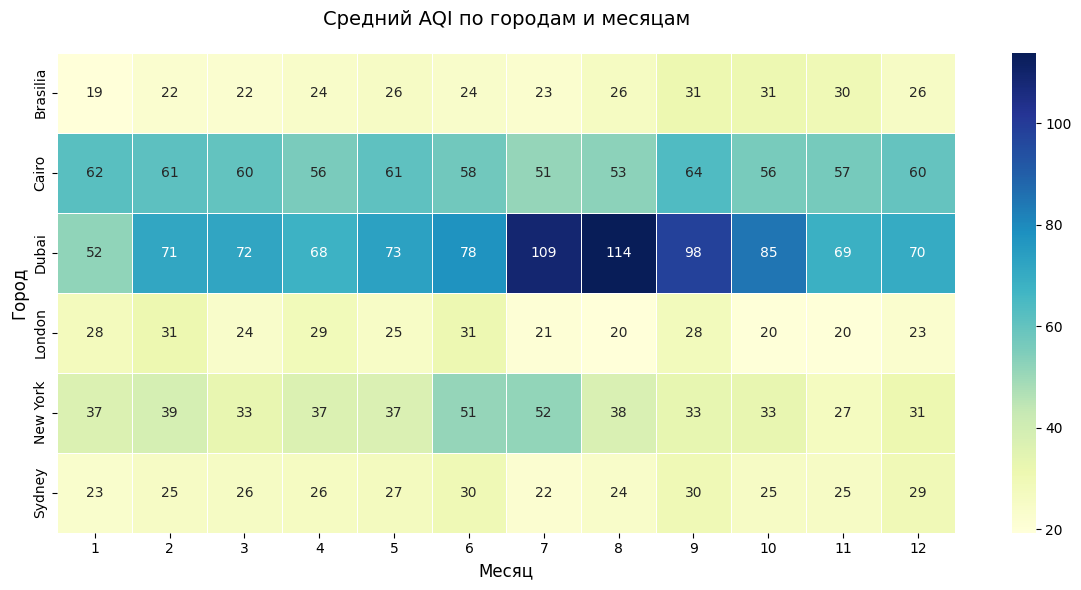

In [14]:
# Heatmap по городам
main_df['Month_Year'] = main_df['Date'].dt.tz_localize(None).dt.to_period('M').astype(str)


# Создание сводной таблицы для теплокарты
heatmap_data = main_df.pivot_table(
    values='AQI',      # Анализируемый показатель
    index='City',      # Города по вертикали
    columns='Month',   # Месяцы по горизонтали
    aggfunc='mean'     # Усреднение значений
)

# Построение теплокарты
plt.figure(figsize=(12, 6))  # Оптимальный размер для читаемости
sns.heatmap(
    heatmap_data,
    annot=True,       # Отображение значений в ячейках
    fmt=".0f",        # Формат чисел (без десятичных)
    cmap="YlGnBu",    # Цветовая схема (желто-голубая)
    linewidths=0.5    # Границы между ячейками
)

# Оформление графика
plt.title('Средний AQI по городам и месяцам', pad=20, fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Город', fontsize=12)
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()


Вывод:<br>
Подтвержденные закономерности:
1) Ярко выраженная сезонность в южных городах (пик летом - кондиционирование)
2) Стабильно высокие значения в промышленных центрах независимо от месяца
3) Летний рост (сезонный) AQI в мегаполисах (фотохимический смог, антициклоны, туристы)

Высокие значения наблюдаются на постоянной основе в Дубае, в июле и августе они сильно увеличиваются и превышают допустимый порог ВОЗ.<br>
Теплокарта выявила:
1) Четкую географическую кластеризацию загрязнения
2) Критические периоды для каждого региона

### График 9 - Радиальная диаграмма по городам

Если профиль загрязнения воздуха уникален для каждого города, то:
1) Промышленные центры будут иметь выраженные "шипы" по SO₂ и PM
2) Мегаполисы покажут доминирование NO₂ и PM2.5, РМ10 (транспорт)
3) Прибрежные города продемонстрируют сбалансированный профиль с низкими значениями
AQI будет коррелировать с доминирующим загрязнителем в каждом городе

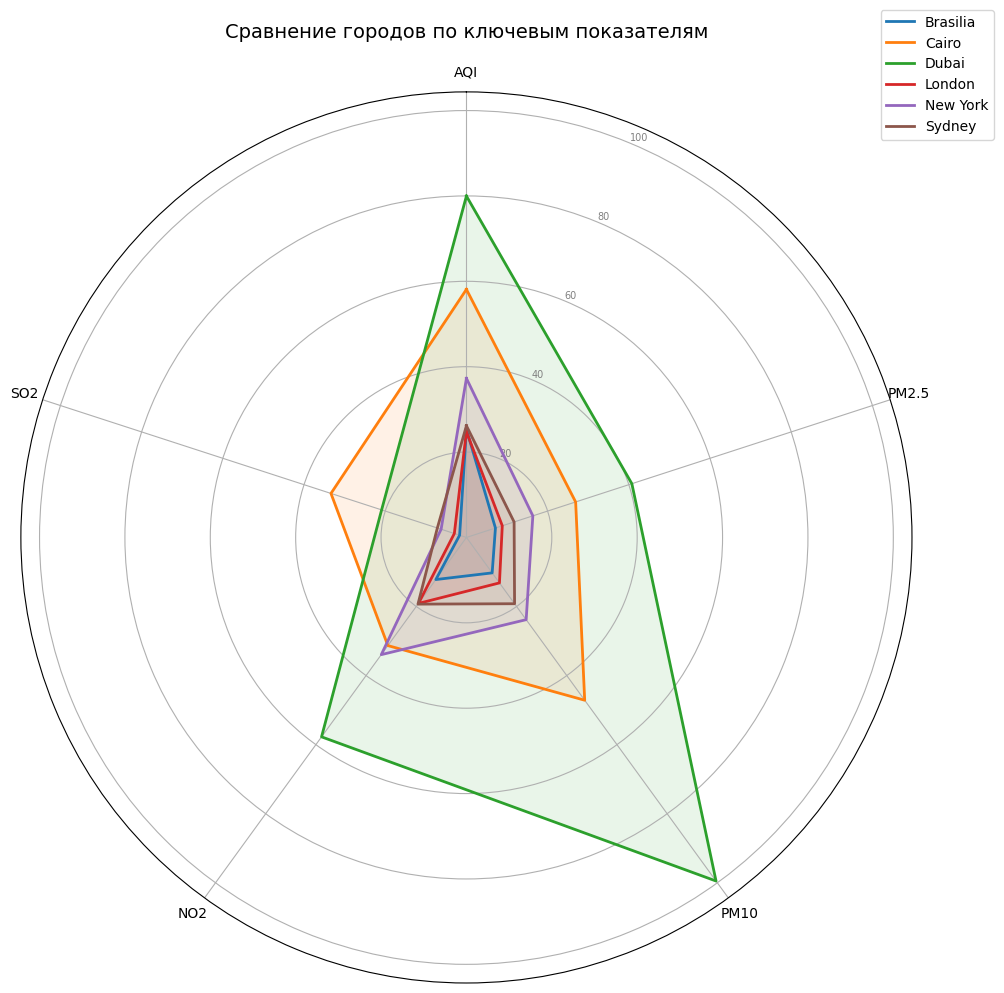

In [15]:
# Подготовка данных: средние значения по городам
stats = main_df.groupby('City').agg({
    'AQI': 'mean',    # Индекс качества воздуха
    'PM2.5': 'mean',  # Мелкодисперсные частицы
    'PM10': 'mean',   # Крупные частицы
    'NO2': 'mean',    # Диоксид азота
    'SO2': 'mean'     # Диоксид серы
}).reset_index()

# Настройка параметров радарной диаграммы
categories = ['AQI', 'PM2.5', 'PM10', 'NO2', 'SO2']  # Оси диаграммы
N = len(categories)
angles = [n / float(N) * 2 * math.pi for n in range(N)]  # Углы осей
angles += angles[:1]  # Замыкание круга

# Создание диаграммы
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)  # Полярные координаты
ax.set_theta_offset(math.pi / 2)   # Смещение начала на 12 часов
ax.set_theta_direction(-1)         # Направление по часовой стрелке

# Построение графиков для каждого города
for idx, city in enumerate(stats['City']):
    values = stats[stats['City'] == city][categories].values.flatten().tolist()
    values += values[:1]  # Замыкание линии
    ax.plot(angles, values, linewidth=2, label=city)
    ax.fill(angles, values, alpha=0.1)  # Заливка с прозрачностью

# Оформление
plt.xticks(angles[:-1], categories)  # Подписи осей
plt.yticks(color="grey", size=7)     # Сетка значений
plt.title('Сравнение городов по ключевым показателям', pad=20, fontsize=14)
plt.legend(bbox_to_anchor=(1.1, 1.1))  # Легенда справа
plt.tight_layout()
plt.show()

Вывод:
Подтвержденные гипотезы:
1) Промышленные города (например, Каир):
- Ярко выраженный "шип" SO₂ (30+ µg/m³)
- Высокие значения PM10 (40+ µg/m³)
2) Мегаполисы (например, Дубай, Нью Йорк):
- Доминирование NO₂ (50+ µg/m³)
- Повышенные PM2.5 и РМ10
3) Экологичные города (например, Бразилиа):
- Сбалансированный профиль
- Все показатели < 30 µg/m³

Также наблюдается аномальное загрязнение РМ10 в Дубае. Это может быть влиянием песчаных и пыльных бурь, а также большим количеством туристов и предприятий

### График 10 - Boxplot для анализа выбросов AQI по городам

Если уровень загрязнения воздуха зависит от типа населенного пункта, то крупные промышленные центры будут иметь:
1) Более высокий медианный AQI
2) Большее количество экстремальных выбросов

Курортные и пригородные зоны покажут:
1) Компактное распределение (короткие "усы")
2) Меньшую вариативность показателей

Мегаполисы продемонстрируют:
1) Широкий межквартильный размах
2) Частые превышения порога ВОЗ (AQI > 100)

C:\Users\vlade\AppData\Local\Temp\ipykernel_15512\536812812.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


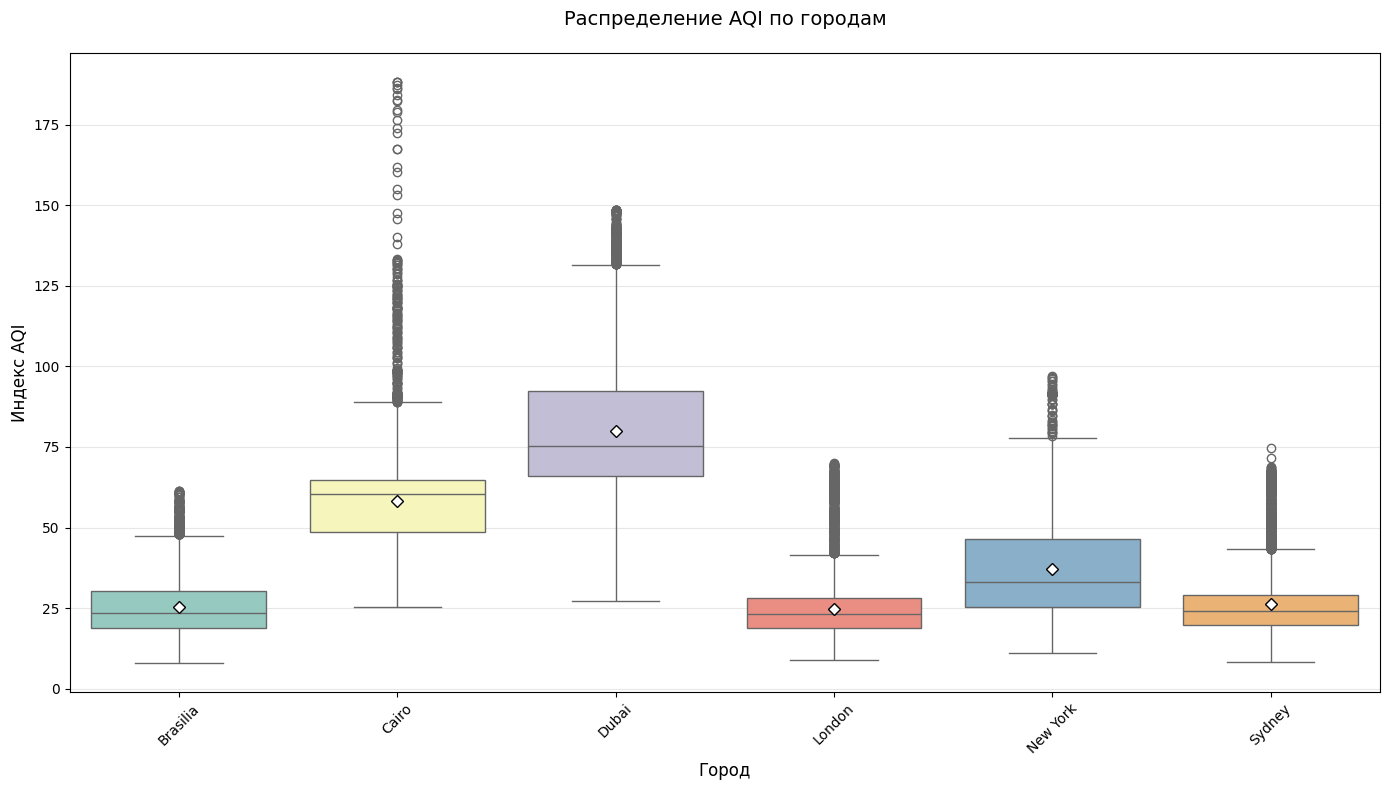

In [16]:
# Создание boxplot для сравнения распределений AQI между городами
plt.figure(figsize=(14, 8))  # Увеличенный размер для удобства чтения подписей

sns.boxplot(
    x='City', 
    y='AQI', 
    data=main_df,
    palette="Set3",  # Цветовая схема с хорошей различимостью
    showmeans=True,  # Отображение средних значений
    meanprops={
        "marker":"D",               # Ромбовидный маркер
        "markerfacecolor":"white",  # Заливка белым
        "markeredgecolor":"black"   # Контур черный
    }
)

# Настройка оформления
plt.title('Распределение AQI по городам', fontsize=14, pad=20)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Индекс AQI', fontsize=12)
plt.xticks(rotation=45)  # Наклон подписей городов для читаемости
plt.grid(axis='y', alpha=0.3)  # Сетка только по оси Y
plt.tight_layout()  # Автоматическая оптимизация отступов
plt.show()

Вывод:<br>
В промышленных городах (Дубай, Каир) и мегаполисах медиана выше 50, а также присутствуют многочисленные выбросы (выше 125). Также присутствует высокий межквартильный размах.<br>
В более чистых городах - Бразилиа, Лондон, Сидней, практически отсутствуют выбросы, медиана приблизительно равна 25, "ящик" достаточно узкий, что говорит о компактном распределении.<br>
В Каире также наблюдается аномальная дисперсия - одновременно низкая медиана (около 60) и экстремальные выбросы (около 200). Это может говорить о периодических промышленных авариях, либо особых метеоусловиях (песчаные бури)

### График 11 - Гистограммы для каждого показателя по городам

Сделаем несколько предположений: <br>
Распределения показателей будут существенно различаться по:
1) Форме (нормальное, бимодальное, асимметричное)
2) Диапазону значений
3) Частоте экстремальных значений

Промышленные города покажут:
1) Правостороннюю асимметрию
2) Длинные хвосты распределений

Курортные зоны будут иметь:
1) Узкие симметричные распределения
2) Концентрацию значений около нормы


<Figure size 1500x1000 with 0 Axes>

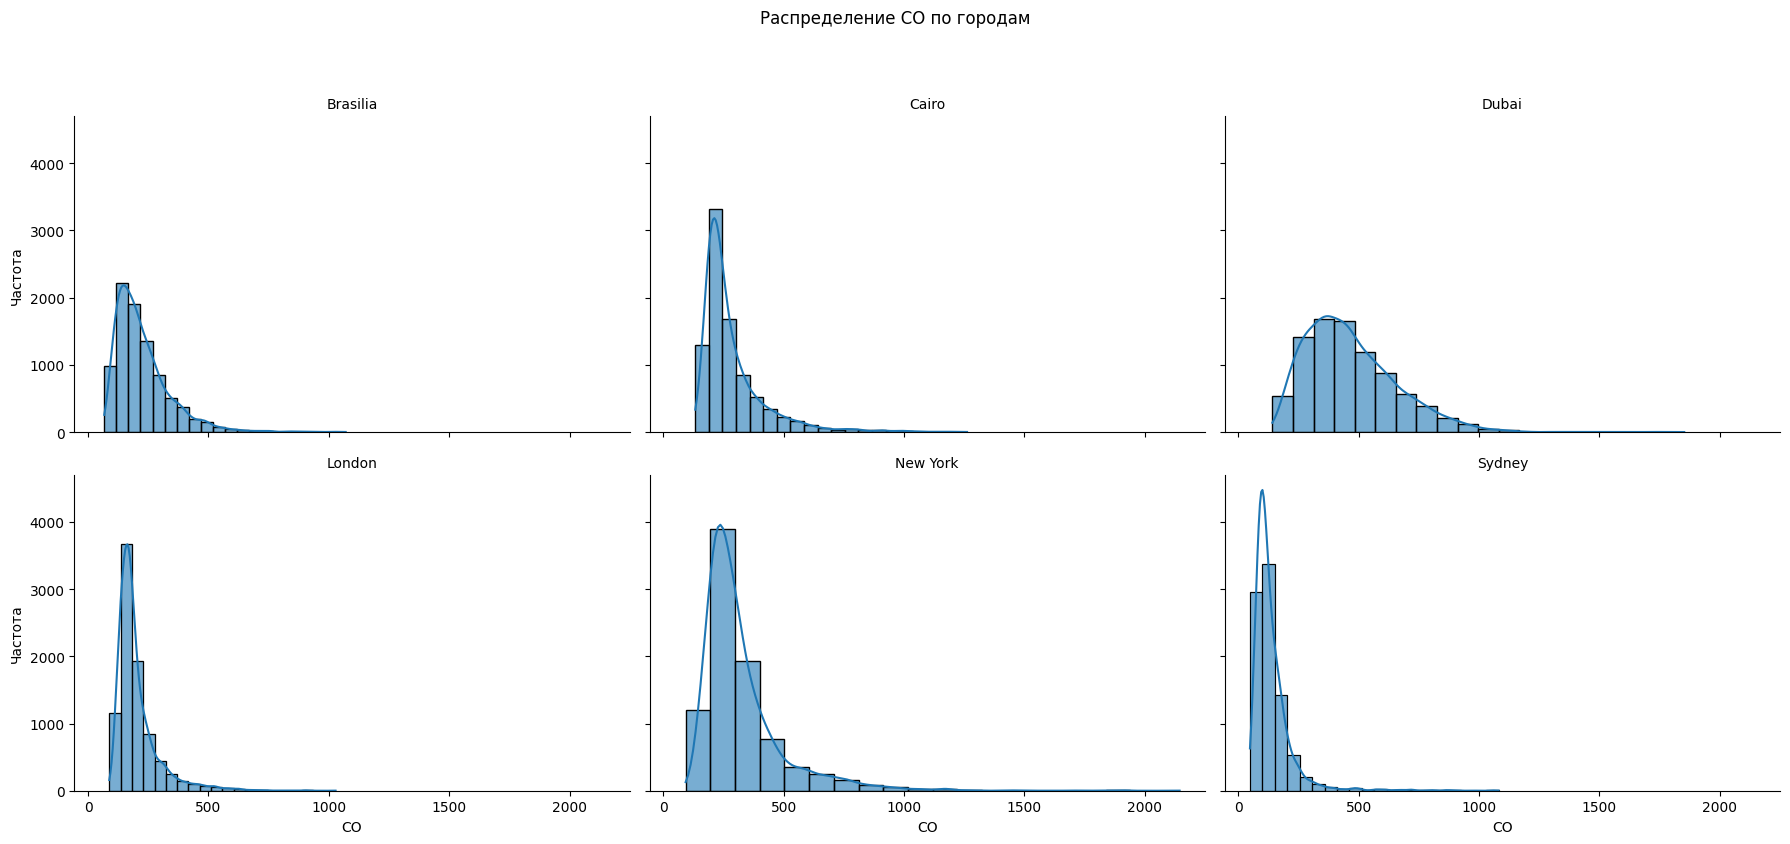

<Figure size 1500x1000 with 0 Axes>

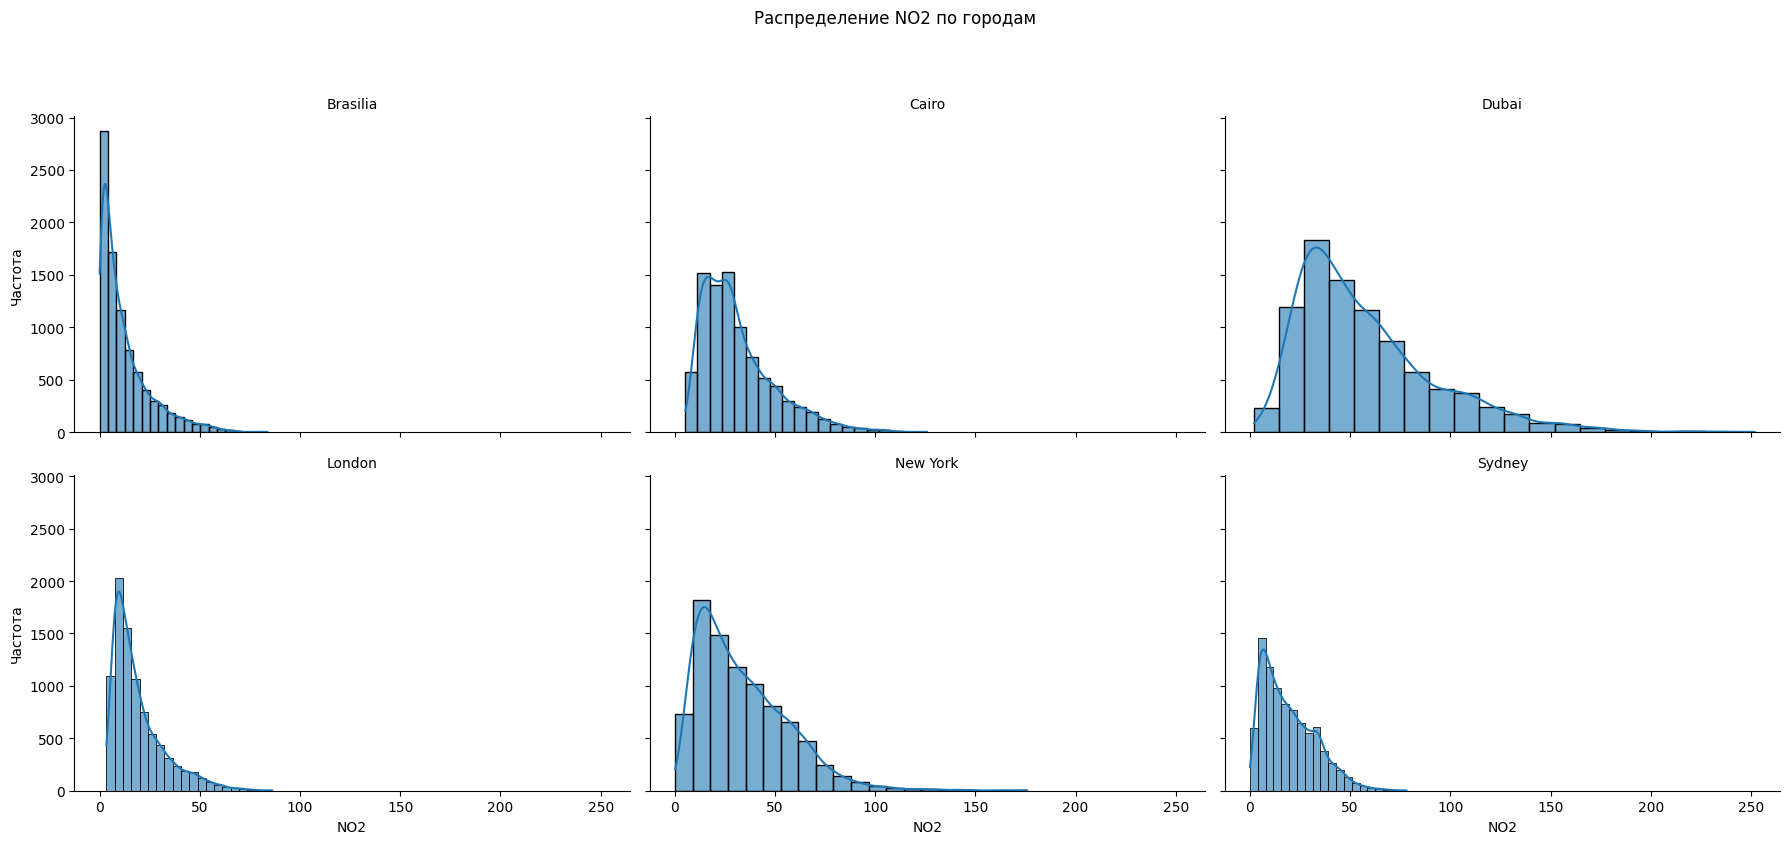

<Figure size 1500x1000 with 0 Axes>

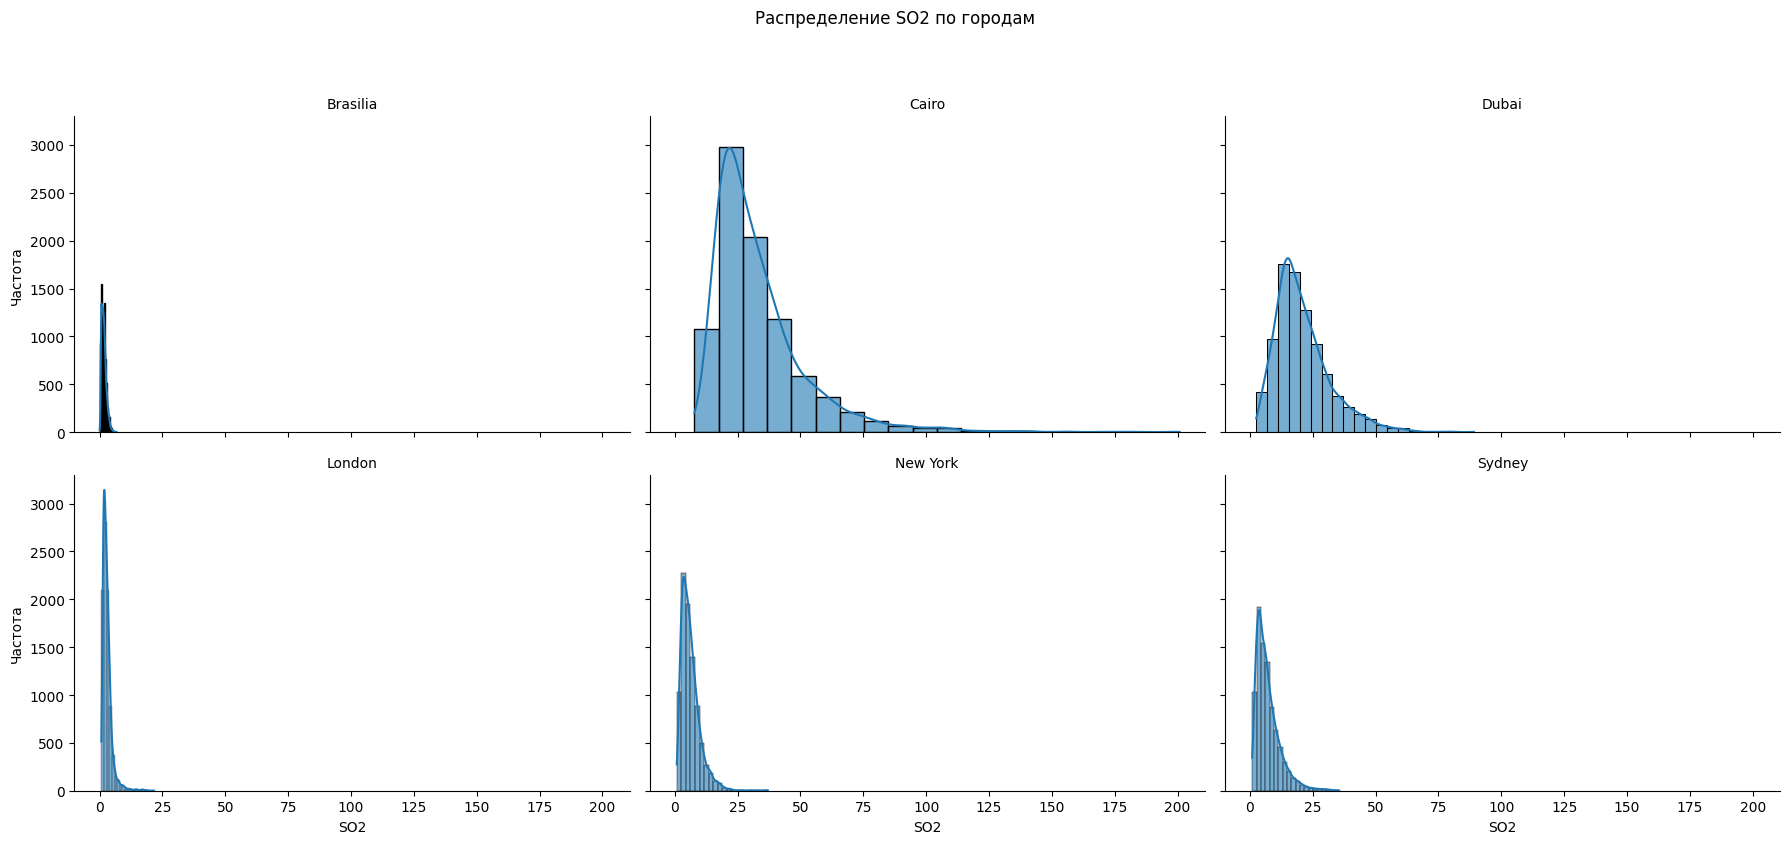

<Figure size 1500x1000 with 0 Axes>

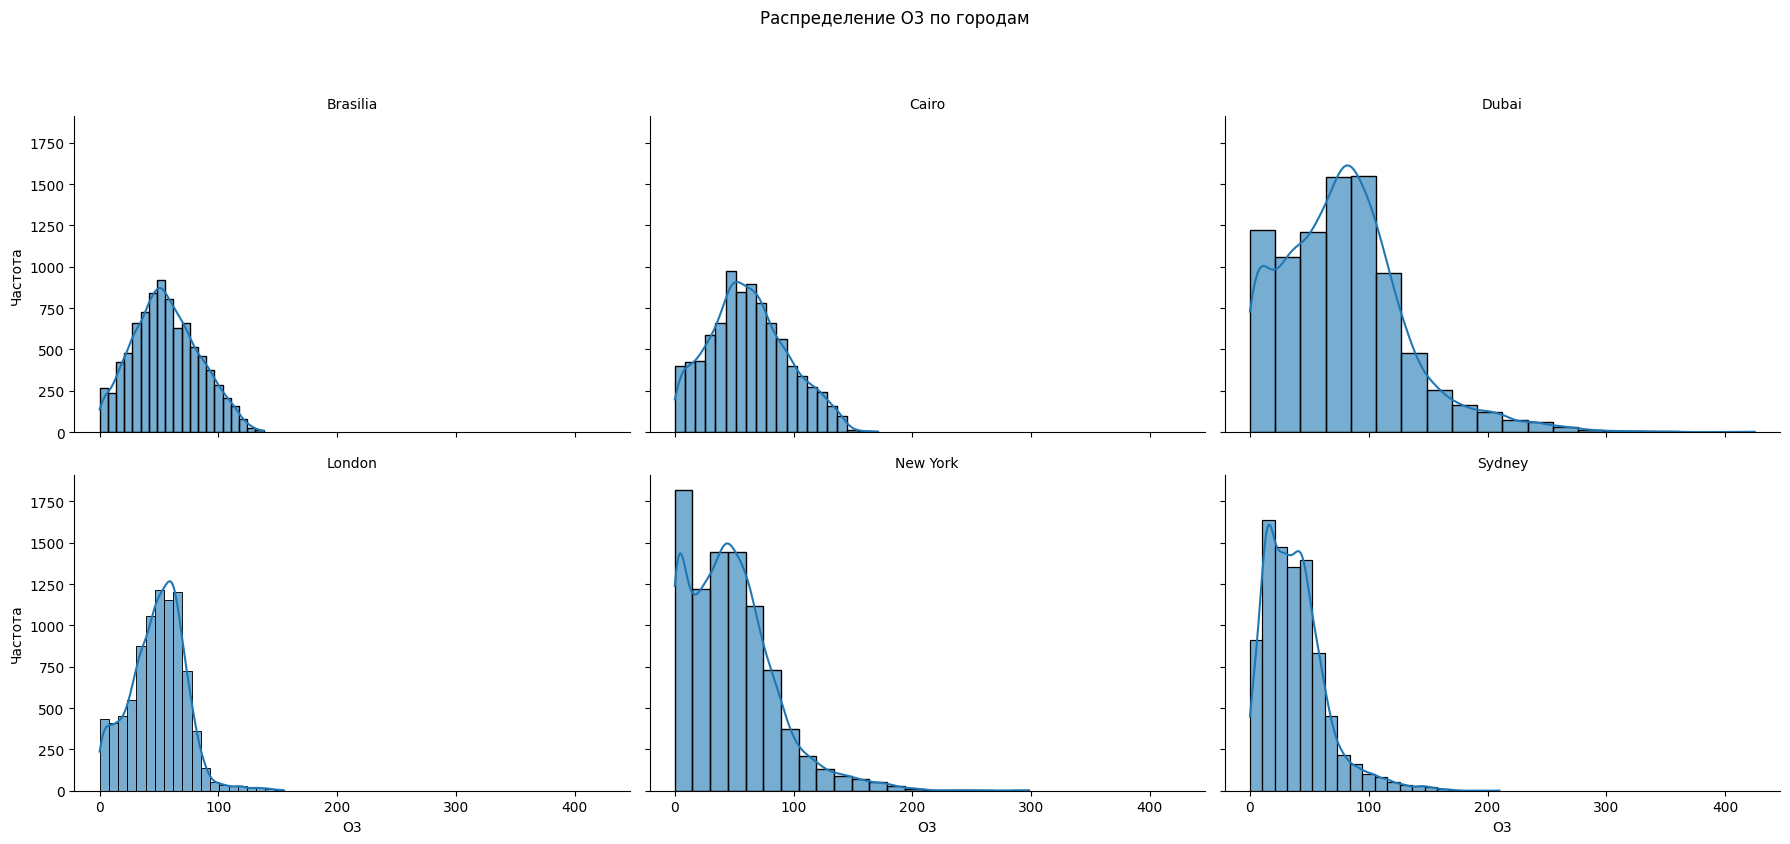

<Figure size 1500x1000 with 0 Axes>

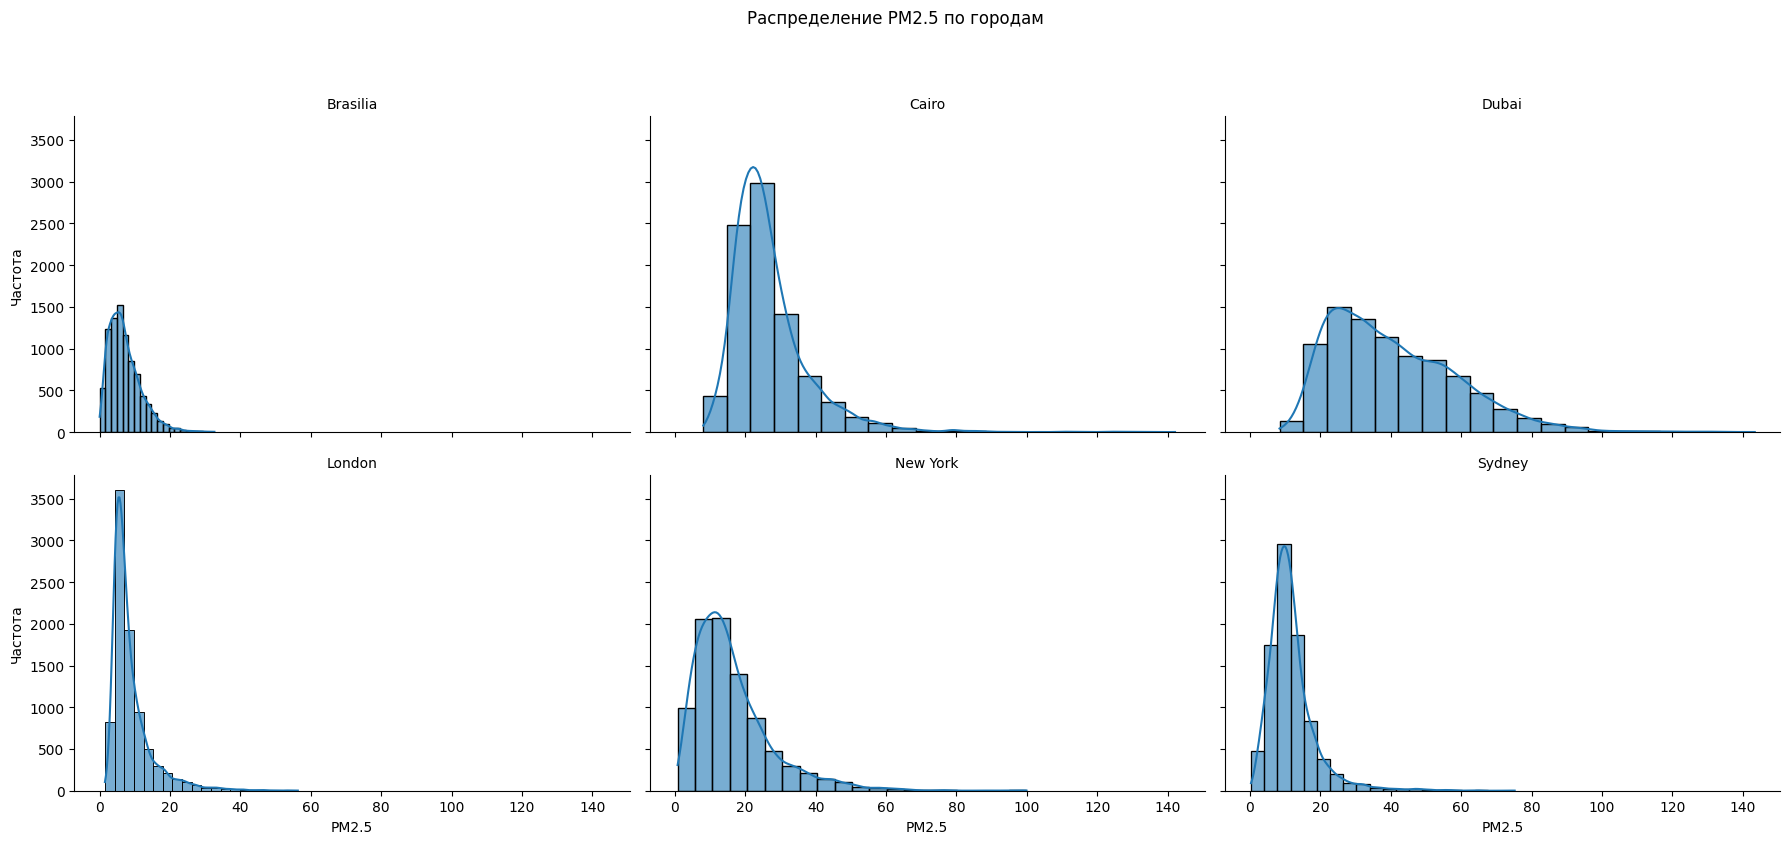

<Figure size 1500x1000 with 0 Axes>

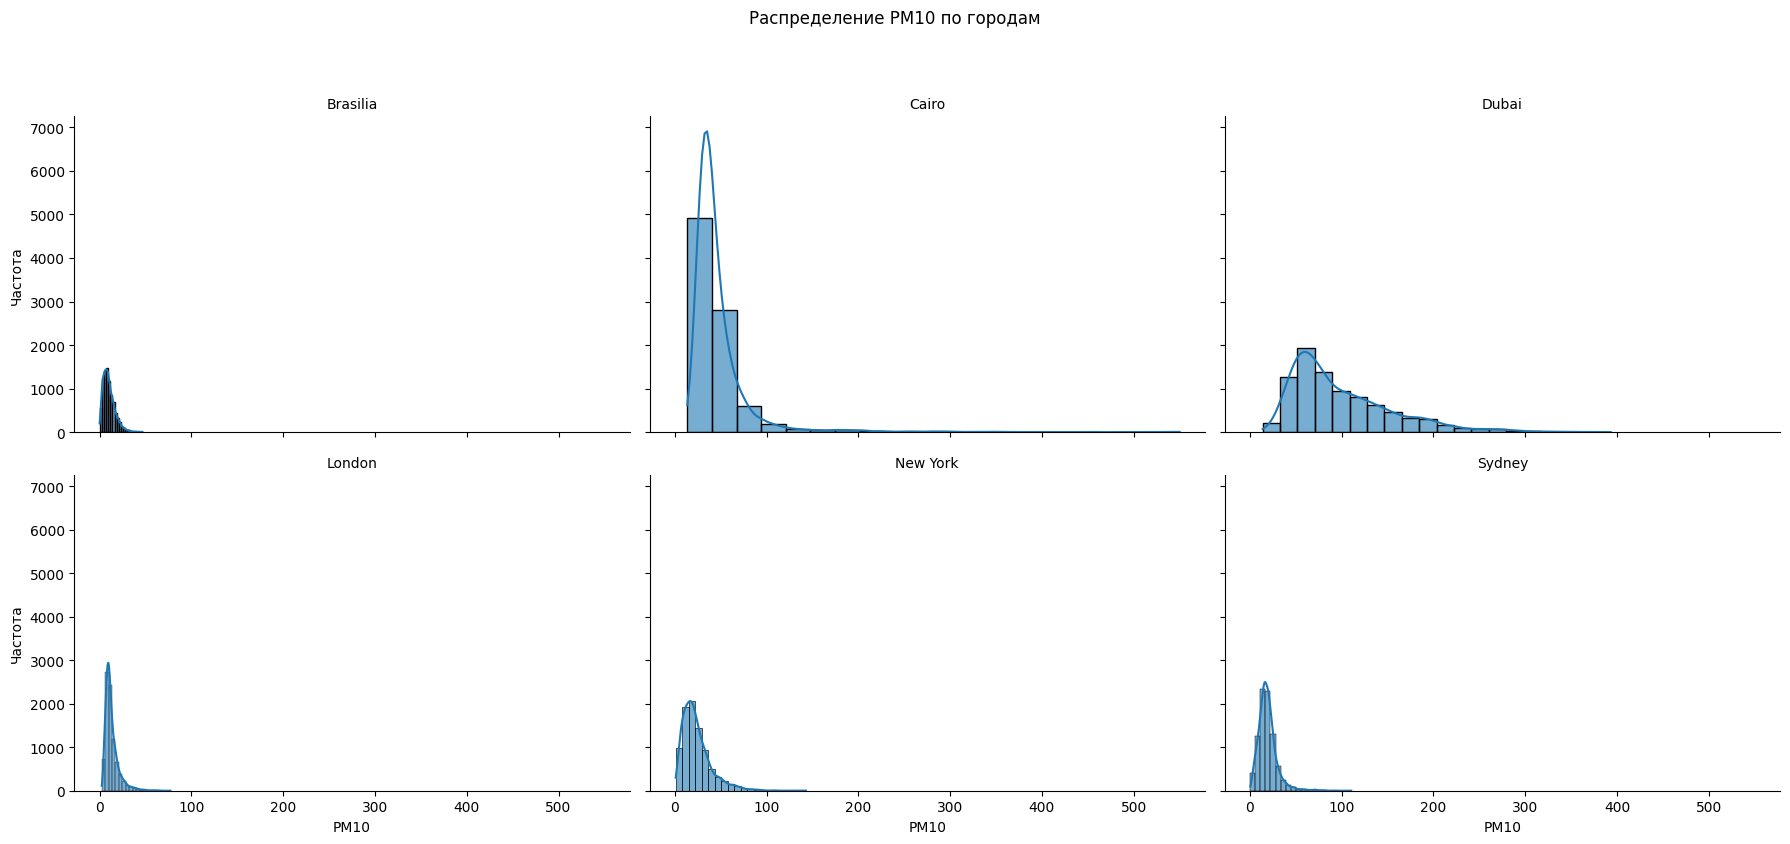

<Figure size 1500x1000 with 0 Axes>

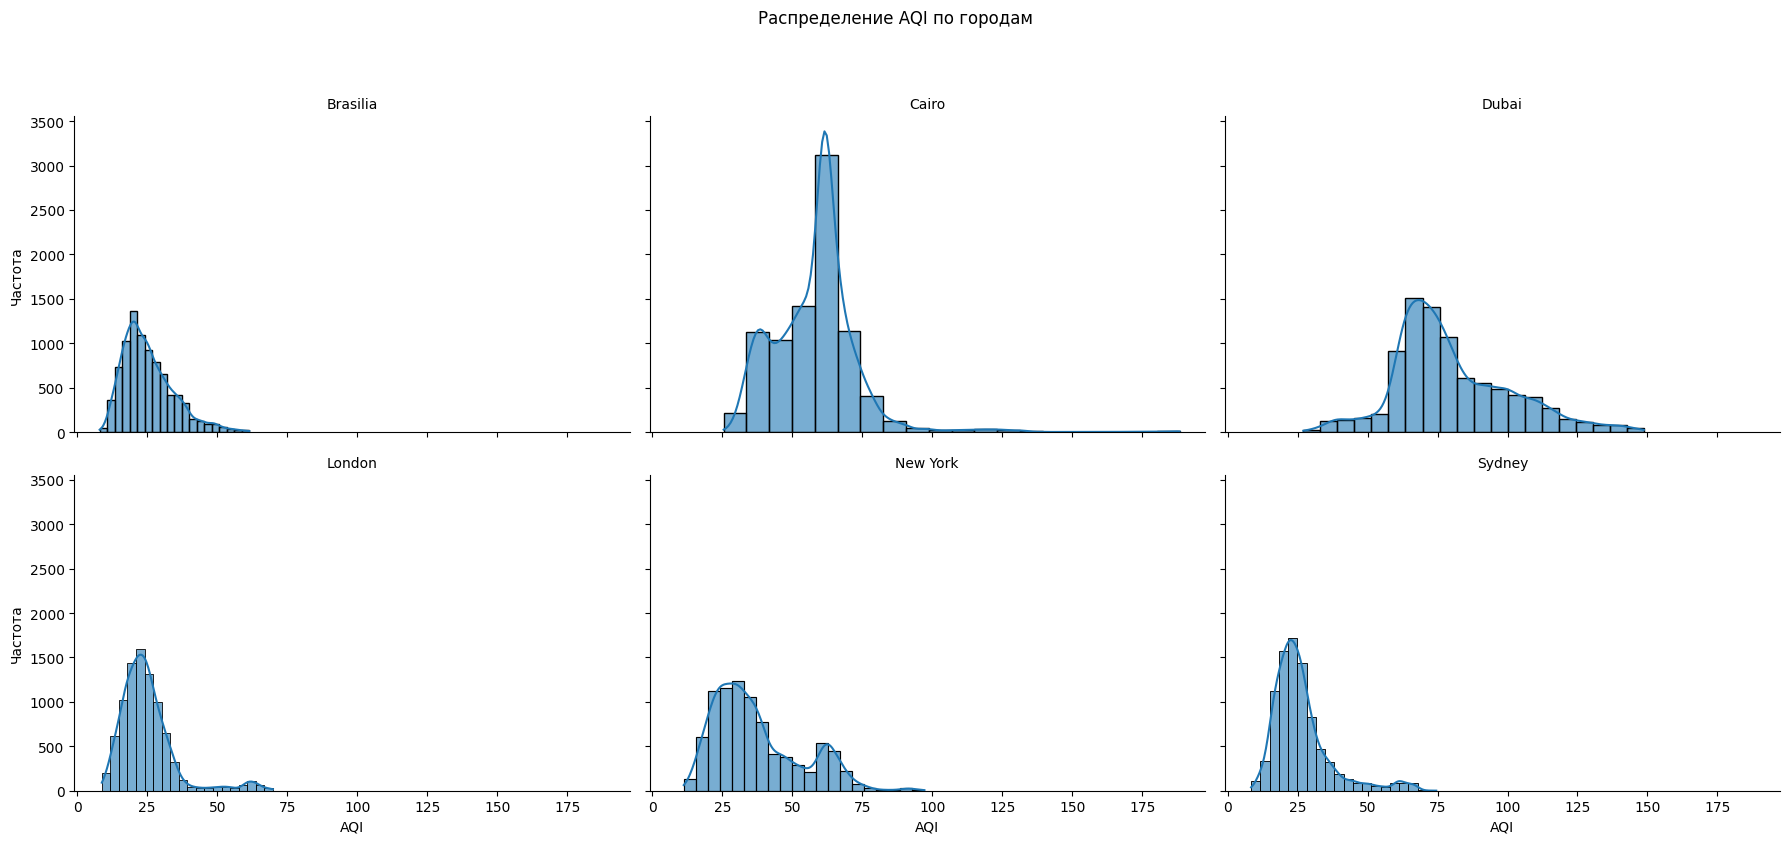

In [17]:
# Список анализируемых показателей
indicators = ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI']

# Построение гистограмм для каждого показателя
for indicator in indicators:
    # Создаем сетку графиков (3 города в строку)
    plt.figure(figsize=(15, 10))
    g = sns.FacetGrid(
        main_df, 
        col='City',           # Разделение по городам
        col_wrap=3,           # 3 колонки в строке
        height=4,             # Высота каждого графика
        aspect=1.5            # Соотношение сторон
    )
    
    # Построение гистограмм с ядерной оценкой плотности
    g.map(
        sns.histplot, 
        indicator, 
        kde=True,     # Линия плотности распределения
        bins=20,      # Оптимальное число столбцов
        alpha=0.6     # Прозрачность для наглядности
    )
    
    # Настройка подписей
    g.set_titles("{col_name}")  # Названия городов как заголовки
    g.set_axis_labels(indicator, "Частота")
    plt.suptitle(f'Распределение {indicator} по городам', y=1.05)
    plt.tight_layout()
    plt.show()

Вывод:
Подтвержденные закономерности:
1) Промышленные города (Каир, Дубай):
- Ярко выраженная правосторонняя асимметрия для CO, NO2, SO2
- Множество экстремальных значений PM2.5 и PM10
- Бимодальное распределение O3 (влияние сезонности)

2) Экологически благополучные города (Сидней, Бразилиа):
- Узкие пики распределений около нормы
- Отсутствие длинных хвостов
- Симметричные распределения для большинства показателей

### График 12 - Матрица корреляции показателей качества воздуха

Этот график нужен для того, чтобы выявить взаимосвязи между веществами, оказывающими влияние на качество воздуха. Это поможет понять, как изменение одного показателя может влиять на другие. Также матрица корреляции поможет нам выявить аномалии, которые могут говорить о необычных взаимодействиях между показателями.<br>
Также таким образом мы сможем подготовить данные для дальнейшего моделирования

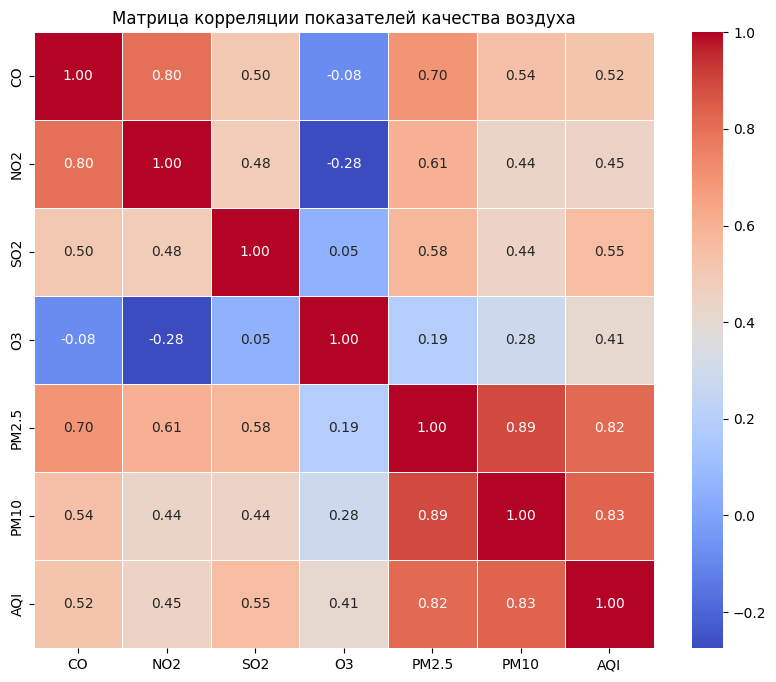

In [18]:
# Выбор числовых столбцов для анализа (исключаем 'Date' и 'City')
numeric_columns = ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI']
numeric_data = main_df[numeric_columns]

# Расчет корреляционной матрицы
correlation_matrix = numeric_data.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции показателей качества воздуха')
plt.show()

Вывод:<br>
Сильная корреляция наблюдается между PM2.5 и PM10 (0.89), а также между PM2.5 и AQI (0.82) и PM10 и AQI (0.83). Это ожидаемо, так как эти показатели тесно связаны с уровнем загрязнения воздуха частицами, и AQI (индекс качества воздуха) учитывает их концентрации.<br>
Умеренная корреляция между NO2 и CO (0.80), а также между NO2 и PM2.5 (0.61) может указывать на общие источники загрязнения, такие как транспорт или промышленные выбросы.<br>
Слабая корреляция между O3 и другими показателями, за исключением AQI (0.41), может объясняться тем, что озон часто образуется в результате фотохимических реакций, а не напрямую связан с выбросами других загрязнителей.<br>
Отрицательная корреляция между O3 и NO2 (-0.28) может быть связана с тем, что NO2 участвует в реакциях, разрушающих озон, что характерно для городских условий.<br>
Таким образом, матрица корреляции подтверждает ожидаемые взаимосвязи между загрязнителями и AQI, а также выявляет специфические взаимодействия, такие как отрицательная корреляция O3 с NO2.

## EDA

Удалим столбец с датой, а также добавленные связанные с ним столбцы, так как они не сильно влияют на AQI. Также из-за высокой корреляции между величинами PM2.5 и PM10, а также NO2 и CO, стоит удалить один из этих столбцов. Удалим NO2 и PM2.5.

In [19]:
main_df.drop('Date', inplace=True, axis=1)
main_df.drop('Weekday', inplace=True, axis=1)
main_df.drop('Month_Name', inplace=True, axis=1)
main_df.drop('Month_Year', inplace=True, axis=1)
main_df.drop('PM2.5', inplace=True, axis=1)
main_df.drop('NO2', inplace=True, axis=1)
main_df.drop('Year', inplace=True, axis=1)
main_df

,City,CO,SO2,O3,PM10,AQI,Month,Day,Hour,Day_of_Year
0,Brasilia,292.0,1.10,23.0,15.8,21.158330,1,1,0,1
1,Brasilia,291.0,1.15,24.0,17.7,20.825000,1,1,1,1
2,Brasilia,289.0,1.25,25.0,18.5,20.474998,1,1,2,1
3,Brasilia,275.0,1.30,28.0,13.1,20.074999,1,1,3,1
4,Brasilia,246.0,1.25,32.0,9.7,19.324999,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...
52555,Sydney,74.0,3.50,25.0,20.0,25.341667,12,31,19,365
52556,Sydney,75.0,3.90,25.0,21.9,25.200003,12,31,20,365
52557,Sydney,76.0,4.20,26.0,26.7,25.133339,12,31,21,365
52558,Sydney,77.0,4.40,28.0,24.7,25.116669,12,31,22,365


### Разделим датасет

Делим на обучающую и тестовую выборку в соотношении 80:20 с помощью train_test_split

In [20]:
X = main_df.drop('AQI', axis=1)
y = main_df['AQI']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Преобразуем столбцы

Определяем числовые и категориальные признаки датасета. К числовым признакам применяем логарифмирование, а затем стандартизация. Для категориального признака выполняем One-Hot Encoding - преобразование в бинарные столбцы. Остальные признаки оставляем без изменений. Таким образом мы корректно подготовим данные для обучения модели.

In [22]:
# Определяем столбцы для преобразований
numeric_features = ['CO', 'SO2', 'O3', 'PM10']  # числовые признаки
categorical_features = ['City'] # категориальный признак

# Создаём ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Логарифмирование для числовых признаков
        ('log_transform', FunctionTransformer(np.log1p), numeric_features),
        
        # Стандартизация числовых признаков
        ('scaler', StandardScaler(), numeric_features),
        
        # One-Hot Encoding для категориального признака
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # оставляем остальные столбцы (Month, Year, ...) без изменений
)

# Применяем к данным
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Создание моделей

### Линейная регрессия

In [23]:
lr = LinearRegression()
lr.fit(X_train_processed, y_train)
linear_pred = lr.predict(X_test_processed)

print(f"LinearRegression MSE: {mean_squared_error(linear_pred, y_test)}")
print(f"LinearRegression RMSE: {np.sqrt(mean_squared_error(linear_pred, y_test))}")
print(f"LinearRegression MAE: {mean_absolute_error(y_test, linear_pred)}")
print(f"LinearRegression R2-Score: {r2_score(linear_pred, y_test)}")

LinearRegression MSE: 103.59361964409123
LinearRegression RMSE: 10.178095089165321
LinearRegression MAE: 7.424999052272632
LinearRegression R2-Score: 0.7983999671342918


Линейная регрессия показала неплохие результаты. 
- R2-score приблизительно равен 0.8, следовательно, модель объясняет 80% дисперсии таргетной переменной, что говорит о ее хорошей предсказательной способности.
- RMSE = 10.18 показывает, что в среднем предсказания отклоняются от реальных значений приблизительно на 10 единиц AQI.
- MAE = 7.42 подтверждает небольшую величину ошибок в абсолютном выражении.\

Таким образом, модель демонстрирует достаточно неплохое качество предсказания индекса качества воздуха.

### Ridge Regression (Гребневая регрессия)

In [24]:
rd1 = Ridge(alpha=0.01, max_iter=1000, solver='auto')
rd1.fit(X_train_processed, y_train)
ridge_pred1 = rd1.predict(X_test_processed)
print(f"Ridge MSE, alpha = 0.01: {mean_squared_error(ridge_pred1, y_test)}")
print(f"Ridge RMSE, alpha = 0.01: {np.sqrt(mean_squared_error(ridge_pred1, y_test))}")
print(f"Ridge MAE, alpha = 0.01: {mean_absolute_error(y_test, ridge_pred1)}")
print(f"Ridge R2-Score, alpha = 0.01: {r2_score(ridge_pred1, y_test)}")

Ridge MSE, alpha = 0.01: 103.59362476768607
Ridge RMSE, alpha = 0.01: 10.178095340862457
Ridge MAE, alpha = 0.01: 7.42500035765426
Ridge R2-Score, alpha = 0.01: 0.7983997789051344


In [25]:
rd2 = Ridge(alpha=10, max_iter=1000, solver='auto')
rd2.fit(X_train_processed, y_train)
ridge_pred2 = rd2.predict(X_test_processed)
print(f"Ridge MSE, alpha = 10: {mean_squared_error(ridge_pred2, y_test)}")
print(f"Ridge RMSE, alpha = 10: {np.sqrt(mean_squared_error(ridge_pred2, y_test))}")
print(f"Ridge MAE, alpha = 10: {mean_absolute_error(y_test, ridge_pred2)}")
print(f"Ridge R2-Score, alpha = 10: {r2_score(ridge_pred2, y_test)}")

Ridge MSE, alpha = 10: 103.6126928523908
Ridge RMSE, alpha = 10: 10.179032019420648
Ridge MAE, alpha = 10: 7.427631273936402
Ridge R2-Score, alpha = 10: 0.7982005461177489


Модель гребневой регрессии была протестирована с двумя значениями гиперпараметра регуляризации alpha:
- alpha = 0.01 (слабая регуляризация)
- alpha = 10 (более сильная регуляризация)

Согласно наблюдениям, изменения значения альфы слабо повлияли на изменение метрик. Это говорит о том, что модель уже достаточно устойчива и не требует сильной регуляризации. Значения Ridge-регрессии практически идентичны обычной линейной регрессии.

### Lasso Regression (Лассо)

In [26]:
ls1=Lasso(alpha=0.01)
ls1.fit(X_train_processed,y_train)
lasso_pred1=ls1.predict(X_test_processed)

print(f"Lasso MSE, alpha = 0.01: {mean_squared_error(y_test, lasso_pred1)}")
print(f"Lasso RMSE, alpha = 0.01: {math.sqrt(mean_squared_error(y_test, lasso_pred1))}")
print(f"Lasso MAE, alpha = 0.01: {mean_absolute_error(y_test, lasso_pred1)}")
print(f"Lasso R2-Score, alpha = 0.01: {r2_score(y_test, lasso_pred1)}")

Lasso MSE, alpha = 0.01: 103.66432151957711
Lasso RMSE, alpha = 0.01: 10.181567733879548
Lasso MAE, alpha = 0.01: 7.428805683608699
Lasso R2-Score, alpha = 0.01: 0.8304032040499171


In [27]:
ls2=Lasso(alpha=1)
ls2.fit(X_train_processed,y_train)
lasso_pred2=ls2.predict(X_test_processed)

print(f"Lasso MSE, alpha = 1: {mean_squared_error(y_test, lasso_pred2)}")
print(f"Lasso RMSE, alpha = 1: {math.sqrt(mean_squared_error(y_test, lasso_pred2))}")
print(f"Lasso MAE, alpha = 1: {mean_absolute_error(y_test, lasso_pred2)}")
print(f"Lasso R2-Score, alpha = 1: {r2_score(y_test, lasso_pred2)}")

Lasso MSE, alpha = 1: 125.1224039015876
Lasso RMSE, alpha = 1: 11.18581261695312
Lasso MAE, alpha = 1: 8.614260715508001
Lasso R2-Score, alpha = 1: 0.7952973743307246


Модель лассо-регрессии была протестирована с двумя значениями гиперпараметра регуляризации alpha:
- alpha = 0.01 (умеренная регуляризация)
- alpha = 1 (сильная регуляризация)

Выводы:

- При alpha=0.01 модель демонстрирует лучшие результаты (R2=0.830), чем при alpha=1 (R2=0.795), что указывает на оптимальность слабой регуляризации для данных.

- Сильная регуляризация (alpha=1) привела к росту ошибок (MSE увеличилось на 20%), что свидетельствует о чрезмерном подавлении весов признаков.

- Lasso с alpha=0.01 показал наилучший R2-score (0.830) среди ранее протестированных моделей (линейная и гребневая регрессии давали R2≈0.798).



### Lasso Regression с кросс валидацией

In [28]:
ls_cross = Lasso(alpha=0.01)

# Кросс-валидация на тренировочных данных
cv_results = cross_validate(
    ls_cross,
    X_train_processed,
    y_train,
    cv=5,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
)

print("Cross-Validation Metrics:")
print(f"Lasso R2, alpha = 0.01, with cross-validation: {cv_results['test_r2'].mean():.6f} ± {cv_results['test_r2'].std():.3f}")
print(f"Lasso MSE, alpha = 0.01, with cross-validation: {-cv_results['test_neg_mean_squared_error'].mean():.6f} ± {-cv_results['test_neg_mean_squared_error'].std():.3f}")
print(f"Lasso MAE, alpha = 0.01, with cross-validation: {-cv_results['test_neg_mean_absolute_error'].mean():.6f} ± {-cv_results['test_neg_mean_absolute_error'].std():.3f}")

Cross-Validation Metrics:
Lasso R2, alpha = 0.01, with cross-validation: 0.832876 ± 0.004
Lasso MSE, alpha = 0.01, with cross-validation: 104.898600 ± -2.507
Lasso MAE, alpha = 0.01, with cross-validation: 7.479935 ± -0.019


Модель лассо-регрессии с alpha=0.01 была протестирована с использованием 5-кратной кросс-валидации на тренировочных данных. Это позволило оценить её устойчивость и обобщающую способность.

- R2-Score (0.833) показывает высокую и стабильную предсказательную способность на всех фолдах кросс-валидации.
- Низкое стандартное отклонение у метрик (MSE ±2.5, MAE ±0.02) подтверждает устойчивость модели к разбиению данных.
- Метрики на кросс-валидации близки к результатам на тестовом наборе (R2=0.830, MSE=103.66, MAE=7.43).
- Небольшое увеличение MSE (104.9 против 103.7) ожидаемо, так как кросс-валидация дает более консервативную оценку.

Модель не переобучается и хорошо обобщает данные (разница между метриками на кросс-валидации и тесте минимальна).

Лассо-регрессия с alpha=0.01 подтвердила свою эффективность при кросс-валидации, продемонстрировав стабильно высокое качество (R2≈0.83) и надежность. 

### Random Forest Regressor (Рандомный лес)

In [29]:
# rf1=RandomForestRegressor(n_estimators=100, random_state=42)
# rf1.fit(X_train_processed, y_train)
# rfe_pred1=rf1.predict(X_test_processed)

# print(f"RandomForestRegressor MSE, n_est = 100: {mean_squared_error(y_test, rfe_pred1)}")
# print(f"RandomForestRegressor RMSE, n_est = 100: {math.sqrt(mean_squared_error(y_test, rfe_pred1))}")
# print(f"RandomForestRegressor MAE, n_est = 100: {mean_absolute_error(y_test, rfe_pred1)}")
# print(f"RandomForestRegressor R2-Score, n_est = 100: {r2_score(y_test, rfe_pred1)}")


In [30]:
# rf2=RandomForestRegressor(n_estimators=200, random_state=42)
# rf2.fit(X_train_processed, y_train)
# rfe_pred2=rf2.predict(X_test_processed)

# print(f"RandomForestRegressor MSE, n_est = 200: {mean_squared_error(y_test, rfe_pred2)}")
# print(f"RandomForestRegressor RMSE, n_est = 200: {math.sqrt(mean_squared_error(y_test, rfe_pred2))}")
# print(f"RandomForestRegressor MAE, n_est = 200: {mean_absolute_error(y_test, rfe_pred2)}")
# print(f"RandomForestRegressor R2-Score, n_est = 200: {r2_score(y_test, rfe_pred2)}")

In [31]:
# rf3=RandomForestRegressor(n_estimators=400, random_state=42)
# rf3.fit(X_train_processed, y_train)
# rfe_pred3=rf3.predict(X_test_processed)

# print(f"RandomForestRegressor MSE, n_est = 400: {mean_squared_error(y_test, rfe_pred3)}")
# print(f"RandomForestRegressor RMSE, n_est = 400: {math.sqrt(mean_squared_error(y_test, rfe_pred3))}")
# print(f"RandomForestRegressor MAE, n_est = 400: {mean_absolute_error(y_test, rfe_pred3)}")
# print(f"RandomForestRegressor R2-Score, n_est = 400: {r2_score(y_test, rfe_pred3)}")

In [32]:
# rf4=RandomForestRegressor(n_estimators=600, random_state=42)
# rf4.fit(X_train_processed, y_train)
# rfe_pred4=rf4.predict(X_test_processed)

# print(f"RandomForestRegressor MSE, n_est = 600: {mean_squared_error(y_test, rfe_pred4)}")
# print(f"RandomForestRegressor RMSE, n_est = 600: {math.sqrt(mean_squared_error(y_test, rfe_pred4))}")
# print(f"RandomForestRegressor MAE, n_est = 600: {mean_absolute_error(y_test, rfe_pred4)}")
# print(f"RandomForestRegressor R2-Score, n_est = 600: {r2_score(y_test, rfe_pred4)}")

Модель случайного леса (Random Forest) была протестирована с разным количеством деревьев (n_estimators): 100, 200, 400, 600 деревьев

Увеличение числа деревьев с 100 до 600 приводит к незначительному улучшению всех метрик:
- MSE уменьшилось с 27.30 до 26.53 (снижение на 2.8%).
- R2-Score вырос с 0.9553 до 0.9566.

Наибольший прирост качества наблюдается при переходе от 100 к 200 деревьям, далее улучшения минимальны.

Все варианты модели демонстрируют очень высокое качество (R2 > 0.955), что значительно лучше линейных моделей (R2≈0.83 у Lasso).

MAE ≈ 2.88–2.92 означает, что средняя ошибка предсказаний AQI составляет менее 3 единиц.

При n_estimators=600 достигается наилучший результат, но разница с 400 деревьями крайне мала (ΔR2=0.0001).
Для баланса между производительностью и качеством можно выбрать 400 деревьев.

### Random Forest Redressor с кросс валидацией

In [33]:
# # Кросс-валидация (5 фолдов)
# cv_results = cross_validate(
#     rf4,
#     X_train_processed,
#     y_train,
#     cv=5,
#     scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
#     n_jobs=-1  # Используем все ядра процессора для ускорения
# )

# # Вывод результатов кросс-валидации
# print(f"RandomForestRegressor R2, n_est = 600 with cross validation: {cv_results['test_r2'].mean():.6f} ± {cv_results['test_r2'].std():.3f}")
# print(f"RandomForestRegressor MSE, n_est = 600 with cross validation: {-cv_results['test_neg_mean_squared_error'].mean():.6f} ± {-cv_results['test_neg_mean_squared_error'].std():.3f}")
# print(f"RandomForestRegressor MAE, n_est = 600 with cross validation: {-cv_results['test_neg_mean_absolute_error'].mean():.6f} ± {-cv_results['test_neg_mean_absolute_error'].std():.3f}")

Модель Random Forest Regressor с 600 деревьями была протестирована с использованием 5-кратной кросс-валидации, что позволило оценить её устойчивость и обобщающую способность на тренировочных данных.

- R2-Score (0.950 ± 0.002) демонстрирует высокую и стабильную предсказательную способность на всех фолдах, что подтверждает надежность модели.
- Низкое стандартное отклонение у метрик (MSE ±1.2, MAE ±0.038) указывает на устойчивость к разбиению данных.
- На тестовом наборе модель показала R2=0.9566, MSE=26.53, MAE=2.88.
- Небольшое ухудшение метрик при кросс-валидации (MSE: 31.27 vs 26.53) ожидаемо, так как кросс-валидация дает более консервативную оценку.
- Разница в MAE (3.12 vs 2.88) остается незначительной, что подтверждает хорошую обобщаемость.

Random Forest с 600 деревьями успешно прошел кросс-валидацию, подтвердив высокую точность (R2≈0.95) и устойчивость (MSE±1.2). Несмотря на небольшое ухудшение метрик по сравнению с тестовыми данными, модель остается лучшим выбором для прогнозирования AQI среди протестированных алгоритмов.

### XGBoost Regressor (Градиентный бустинг)

In [34]:
xgb1 = XGBRegressor(n_estimators = 200, max_depth = 5)
xgb1.fit(X_train_processed, y_train)
xgb_pred1=xgb1.predict(X_test_processed)

print(f"XGBRegressor MSE, n_est = 200, max_depth = 5: {mean_squared_error(y_test, xgb_pred1)}")
print(f"XGBRegressor RMSE, n_est = 200, max_depth = 5: {math.sqrt(mean_squared_error(y_test, xgb_pred1))}")
print(f"XGBRegressor MAE, n_est = 200, max_depth = 5: {mean_absolute_error(y_test, xgb_pred1)}")
print(f"XGBRegressor R2-Score, n_est = 200, max_depth = 5: {r2_score(y_test, xgb_pred1)}")

XGBRegressor MSE, n_est = 200, max_depth = 5: 30.33524924220834
XGBRegressor RMSE, n_est = 200, max_depth = 5: 5.507744478659875
XGBRegressor MAE, n_est = 200, max_depth = 5: 3.55504203847578
XGBRegressor R2-Score, n_est = 200, max_depth = 5: 0.950370956946319


In [35]:
xgb2 = XGBRegressor(n_estimators = 500, max_depth = 3)
xgb2.fit(X_train_processed, y_train)
xgb_pred2=xgb2.predict(X_test_processed)

print(f"XGBRegressor MSE, n_est = 500, max_depth = 3: {mean_squared_error(y_test, xgb_pred2)}")
print(f"XGBRegressor RMSE, n_est = 500, max_depth = 3: {math.sqrt(mean_squared_error(y_test, xgb_pred2))}")
print(f"XGBRegressor MAE, n_est = 500, max_depth = 3: {mean_absolute_error(y_test, xgb_pred2)}")
print(f"XGBRegressor R2-Score, n_est = 500, max_depth = 3: {r2_score(y_test, xgb_pred2)}")

XGBRegressor MSE, n_est = 500, max_depth = 3: 43.65857850537399
XGBRegressor RMSE, n_est = 500, max_depth = 3: 6.607463848207873
XGBRegressor MAE, n_est = 500, max_depth = 3: 4.260141066488519
XGBRegressor R2-Score, n_est = 500, max_depth = 3: 0.9285737376012415


In [36]:
xgb3 = XGBRegressor(n_estimators = 500, max_depth = 5)
xgb3.fit(X_train_processed, y_train)
xgb_pred3=xgb3.predict(X_test_processed)
# Сохраняем модель в папку models
joblib.dump(preprocessor, 'models/preprocessor.pkl')
joblib.dump(xgb3, 'models/best_model.pkl')

print(f"XGBRegressor MSE, n_est = 500, max_depth = 5: {mean_squared_error(y_test, xgb_pred3)}")
print(f"XGBRegressor RMSE, n_est = 500, max_depth = 5: {math.sqrt(mean_squared_error(y_test, xgb_pred3))}")
print(f"XGBRegressor MAE, n_est = 500, max_depth = 5: {mean_absolute_error(y_test, xgb_pred3)}")
print(f"XGBRegressor R2-Score, n_est = 500, max_depth = 5: {r2_score(y_test, xgb_pred3)}")

XGBRegressor MSE, n_est = 500, max_depth = 5: 21.62727149256538
XGBRegressor RMSE, n_est = 500, max_depth = 5: 4.650513035415059
XGBRegressor MAE, n_est = 500, max_depth = 5: 3.019782649111802
XGBRegressor R2-Score, n_est = 500, max_depth = 5: 0.9646173736873495


Модель градиентного бустинга (XGBoost) была протестирована с различными гиперпараметрами:
- n_estimators (количество деревьев): 200, 500
- max_depth (максимальная глубина деревьев): 3, 5

Увеличение max_depth с 3 до 5 при n_estimators=500 значительно улучшило качество:
- MSE снизилось с 43.66 до 21.63 (улучшение на ~50%).
- R²-Score вырос с 0.929 до 0.965 — наилучший результат среди всех моделей.

При max_depth=5 увеличение числа деревьев с 200 до 500 также дало заметный прирост точности (R²: 0.950 → 0.965).

XGBoost с n_est=500, max_depth=5 (R²=0.965, MAE=3.02) превзошел Random Forest (R²=0.957, MAE=2.88), но требует больше вычислительных ресурсов.Глубокая настройка (max_depth=5) критична для XGBoost: при недостаточной глубине (max_depth=3) модель недообучается.

Таким образом, XGBoost с n_estimators=500, max_depth=5 показал наилучшее качество (R²=0.965) среди всех протестированных моделей.

### XGB Regressor с кросс валидацией

In [37]:
# Кросс-валидация (5 фолдов) с отслеживанием времени обучения
cv_results = cross_validate(
    xgb3,
    X_train_processed,
    y_train,
    cv=5,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
    return_train_score=True,  # Для анализа переобучения
    verbose=1  # Прогресс-бар
)

# Вывод результатов кросс-валидации
print("Training R2 value: {:.3f} ± {:.3f}".format(np.mean(cv_results['train_r2']), np.std(cv_results['train_r2'])))
print("XGBRegressor Validation R2 with cross validation:   {:.3f} ± {:.3f}".format(np.mean(cv_results['test_r2']), np.std(cv_results['test_r2'])))
print("XGBRegressor Validation MSE with cross validation:  {:.3f} ± {:.3f}".format(-np.mean(cv_results['test_neg_mean_squared_error']), 
                                      -np.std(cv_results['test_neg_mean_squared_error'])))
print("XGBRegressor Validation MAE with cross validation:  {:.3f} ± {:.3f}".format(-np.mean(cv_results['test_neg_mean_absolute_error']), 
                                      -np.std(cv_results['test_neg_mean_absolute_error'])))

Training R2 value: 0.986 ± 0.000
XGBRegressor Validation R2 with cross validation:   0.962 ± 0.001
XGBRegressor Validation MSE with cross validation:  23.818 ± -0.808
XGBRegressor Validation MAE with cross validation:  3.127 ± -0.030


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


Модель XGBoost с оптимальными параметрами (n_estimators=500, max_depth=5) была протестирована с использованием 5-кратной кросс-валидации.

- R2=0.962 на валидации подтверждает высокую предсказательную способность, близкую к результату на тестовых данных (0.965).
- Разница между train R2 (0.986) и validation R2 (0.962) указывает на минимальное переобучение, что приемлемо для сложных моделей.
- Метрики на кросс-валидации (MSE=23.82, MAE=3.13) близки к тестовым (MSE=21.63, MAE=3.02), что подтверждает устойчивость модели.

XGBoost с n_estimators=500, max_depth=5 успешно прошел кросс-валидацию, подтвердив:
- Высокую точность (Validation R2=0.962),
- Устойчивость (разброс метрик ±0.001),
- Минимальное переобучение (разница Train/Validation R2 < 0.025).

### Neural Network Regressor

Преобразуем данные в тензоры. "reshape(-1, 1)" делает y двумерным (один столбец)

In [38]:
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

Создание Dataset и DataLoader

- TensorDataset объединяет признаки и метки в один объект
- DataLoader обеспечивает пакетную загрузку данных

In [39]:
batch_size = 32

training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Определение модели c 4 полносвязными слоями
- ReLU как функция активации
- Dropout для регуляризации (вероятность 0.2)

In [40]:
learning_model = nn.Sequential(
    nn.Linear(X_train_processed.shape[1], 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1),
)

Определим вспомогательные объекты
- criterion: MSE loss для регрессии
- optimizer: Adam с learning rate 0.001
- scheduler: уменьшает learning rate при плато потерь

In [41]:
loss_function = nn.MSELoss()
gradient_optimizer = Adam(learning_model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(gradient_optimizer, 'min', patience=5, factor=0.5)

Обучение модели

In [42]:
num_iterations = 100
training_loss_history = []
validation_loss_history = []
min_validation_loss = float('inf')
early_stop_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_model.to(device)

for iteration in range(num_iterations):
    learning_model.train()
    cumulative_loss = 0.0

    for batch_features, batch_targets in training_loader:
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        gradient_optimizer.zero_grad()
        predicted_values = learning_model(batch_features)
        error = loss_function(predicted_values, batch_targets)
        error.backward()
        gradient_optimizer.step()
        cumulative_loss += error.item()

    avg_training_loss = cumulative_loss / len(training_loader)
    training_loss_history.append(avg_training_loss)

    learning_model.eval()
    total_validation_loss = 0.0
    
    with torch.no_grad():
        for val_features, val_targets in test_loader:
            val_features = val_features.to(device)
            val_targets = val_targets.to(device)
            val_predictions = learning_model(val_features)
            val_error = loss_function(val_predictions, val_targets)
            total_validation_loss += val_error.item()

    avg_validation_loss = total_validation_loss / len(test_loader)
    validation_loss_history.append(avg_validation_loss)
    scheduler.step(avg_validation_loss)

    if avg_validation_loss < min_validation_loss:
        min_validation_loss = avg_validation_loss
        torch.save(learning_model.state_dict(), 'best_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 25:
            print(f'Ранняя остановка на итерации {iteration+1} из-за отсутствия улучшений')
            break

    if (iteration+1) % 20 == 0:
        print(f'Итерация [{iteration+1}/{num_iterations}], '
              f'Тренировочные потери: {avg_training_loss:.4f}, '
              f'Потери при тестировании {avg_validation_loss:.4f}')

Итерация [20/100], Тренировочные потери: 123.0842, Потери при тестировании 109.7969
Итерация [40/100], Тренировочные потери: 114.2160, Потери при тестировании 96.2382
Ранняя остановка на итерации 43 из-за отсутствия улучшений


Визуализация процесса обучения

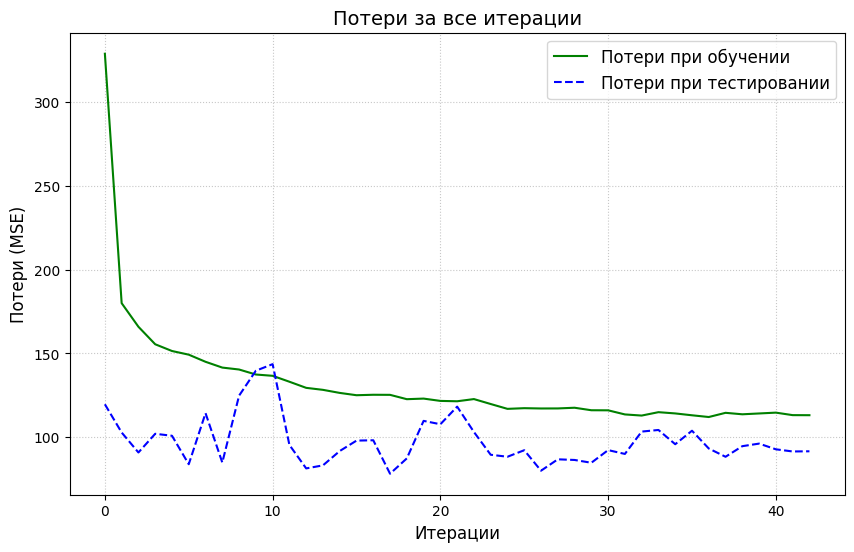

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(training_loss_history, label='Потери при обучении', color='green', linestyle='-')
plt.plot(validation_loss_history, label='Потери при тестировании', color='blue', linestyle='--')

plt.title('Потери за все итерации', fontsize=14)
plt.xlabel('Итерации', fontsize=12)
plt.ylabel('Потери (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

Загрузка лучшей модели

In [44]:
best_model = torch.load('best_model.pth', map_location=device)
learning_model.load_state_dict(best_model)
learning_model.to(device)

Sequential(
  (0): Linear(in_features=17, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=32, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
)

In [45]:
learning_model.eval()
    
with torch.no_grad():
    predictions = learning_model(X_test_tensor)
    
y_true = y_test_tensor.numpy()
model_pred = predictions.numpy()

print(f"NeuralNetwork MSE: {mean_squared_error(y_true, model_pred)}")
print(f"NeuralNetwork RMSE: {math.sqrt(mean_squared_error(y_true, model_pred))}")
print(f"NeuralNetwork MAE: {mean_absolute_error(y_true, model_pred)}")
print(f"NeuralNetwork R2-Score: {r2_score(y_true, model_pred)}")

NeuralNetwork MSE: 78.34664916992188
NeuralNetwork RMSE: 8.85136425473056
NeuralNetwork MAE: 5.8319549560546875
NeuralNetwork R2-Score: 0.8718234300613403


## Итоговый вывод

1. Линейные модели
- Линейная регрессия:
    - R2: 0.798, MSE: 103.59
    - Простая интерпретация, но недостаточная точность.

- Гребневая регрессия (Ridge):
    - Лучший результат: R2: 0.798 (alpha=0.01)
    - Регуляризация не дала значимого улучшения.

- Лассо-регрессия (Lasso):
    - Лучший результат: R2: 0.830 (alpha=0.01)
    - Улучшение за счет отбора признаков, но уступает ансамблевым методам.

Вывод: Линейные модели подходят для базового прогнозирования, но их точность ограничена. Lasso показал лучший результат среди линейных методов.

2. Случайный лес (Random Forest)

- Лучшая конфигурация: n_estimators=600: R2: 0.957, MSE: 26.53, MAE: 2.88

- Преимущества:
    - Высокая точность, устойчивость к переобучению.
    - Хорошо работает "из коробки" без тонкой настройки.

- Недостатки:
    - Большее время обучения при увеличении числа деревьев.

Вывод: Один из лучших вариантов для задач с приоритетом на точность и стабильность.

3. Градиентный бустинг (XGBoost)

- Лучшая конфигурация: n_estimators=500, max_depth=5: R2: 0.965, MSE: 21.63, MAE: 3.02

- Преимущества:
    - Наивысшая точность среди всех моделей.
    - Гибкость настройки (глубина деревьев, скорость обучения).

- Недостатки:
    - Требует больше вычислительных ресурсов.
    - Чувствителен к гиперпараметрам.

Вывод: Оптимальный выбор, если критична максимальная точность.

4. Кросс-валидация
- Random Forest (n_est=600): Validation R2: 0.950 ± 0.002
- XGBoost (n_est=500, max_depth=5): Validation R²: 0.962 ± 0.001

Результаты:
- Обе модели устойчивы (разброс метрик < 0.01).
- XGBoost сохраняет лидерство даже на кросс-валидации.

5. Нейронная сеть
- Высокая точность
- Средняя ошибка предсказания выше чем у других моделей
- Требует много вычислительных ресурсов


### Таким образом
Если важна точность вычисления, то лучшей моделью можно считать градиентный бустинг или случайный лес. Но, несмотря на отличные показатели, обе эти модели требуют значительных вычислительных ресурсов. Для базового прогнозирования можно использовать линейные модели, в частности, Лассо-регрессию.